In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

plt.rcParams['font.size'] = 20

In [3]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
data_folder = os.path.join(package_folder, 'data')

selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

loc = 'nw2'
turbine = 'c02'
mode = 'whirling'

In [4]:
from src.data.make_dataset import *

test_data_path = '_'.join([loc, turbine, 'SS2', 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))
#remove duplicated index
duplicated_indices = test_turbine_data.index.duplicated(keep='first')
test_turbine_data = test_turbine_data[~duplicated_indices]
test_turbine_data.index = pd.to_datetime(test_turbine_data.index, utc=True)

wandelaar_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_wandelaar_weather_data.parquet'))
westhinder_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_westhinder_weather_data.parquet'))

mvbc_test_data = wandelaar_weather_station_data.copy()
mvbc_test_data[mvbc_test_data.filter(regex='Tide').columns] = westhinder_weather_station_data.filter(regex='Tide').values
#mvbc_test_data.rename(columns={mvbc_test_data.filter(regex='Tide').columns[0] :westhinder_weather_station_data.filter(regex='Tide').columns[0]}, inplace=True)
mvbc_test_data.isna().sum()
mvbc_test_data.index = pd.to_datetime(mvbc_test_data.index, utc=True)

smart_tracked_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'smart_tracked_modes.parquet'))

from src.data.utils import synchronize_data
from src.data.preprocessing import sin_cos_angle_inputs
X =  synchronize_data({'turbine_data': test_turbine_data, 'weather_data': mvbc_test_data})
X = sin_cos_angle_inputs(X)
X = X[selected_columns]

In [5]:
from src.data.modal_data import *
mpe_ss_data = get_mpe_data(test_turbine_data, 'SS', loc, turbine)

In [6]:
# reference-based tracking
mean_ = 1.03
var_ = 0.06

ss2_reference_based = mpe_ss_data[(mpe_ss_data['mean_frequency'] > mean_-var_) & (mpe_ss_data['mean_frequency'] < mean_+var_)]

In [7]:
# Get the model

import pickle
models_folder = os.path.join(package_folder, 'models', loc)
model_path = os.path.join(models_folder, 'catboost_model_large.pkl')
with open(model_path, 'rb') as file:
    regr_model = pickle.load(file)

In [348]:
predictions_df = pd.DataFrame(regr_model.predict(X), index=X.index, columns=['predicted_frequency', 'total_uncertainty'])
predictions_virutal_ensemble = \
    pd.DataFrame(
        regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=100, ntree_end=500),
        index=X.index,
        columns=['predicted_frequency', 'knowledge_uncertainty', 'data_uncertainty'])

uncertainty_lim = 2.1331375333164705e-07 #3.778378113097412e-07 #5.902143777376365e-07 #1.199509060664933e-06 #3.215489902573316e-07 #2.6368465309163476e-07
prediction_lim = 2*0.01234057134995788 #0.04178989150095727 #

In [349]:
# model-based tracking
from src.smart_tracking.smart_tracking import smart_tracking
ss2_model_based = smart_tracking(mpe_ss_data['mean_frequency'], predictions_df['predicted_frequency'], predictions_virutal_ensemble['knowledge_uncertainty'], 10, prediction_lim)

In [350]:
# smart tracking
ss2_smart_tracking = smart_tracking(
    mpe_ss_data['mean_frequency'], predictions_df['predicted_frequency'],
    predictions_virutal_ensemble['knowledge_uncertainty'],
    uncertainty_lim, prediction_lim)
# ss2_smart_tracking = smart_tracking(
#     mpe_ss_data['mean_frequency'], 
#     predictions_df['predicted_frequency'], 
#     predictions_virutal_ensemble['knowledge_uncertainty'].rolling(6, center=True).mean(), 
#     uncertainty_lim, prediction_lim)

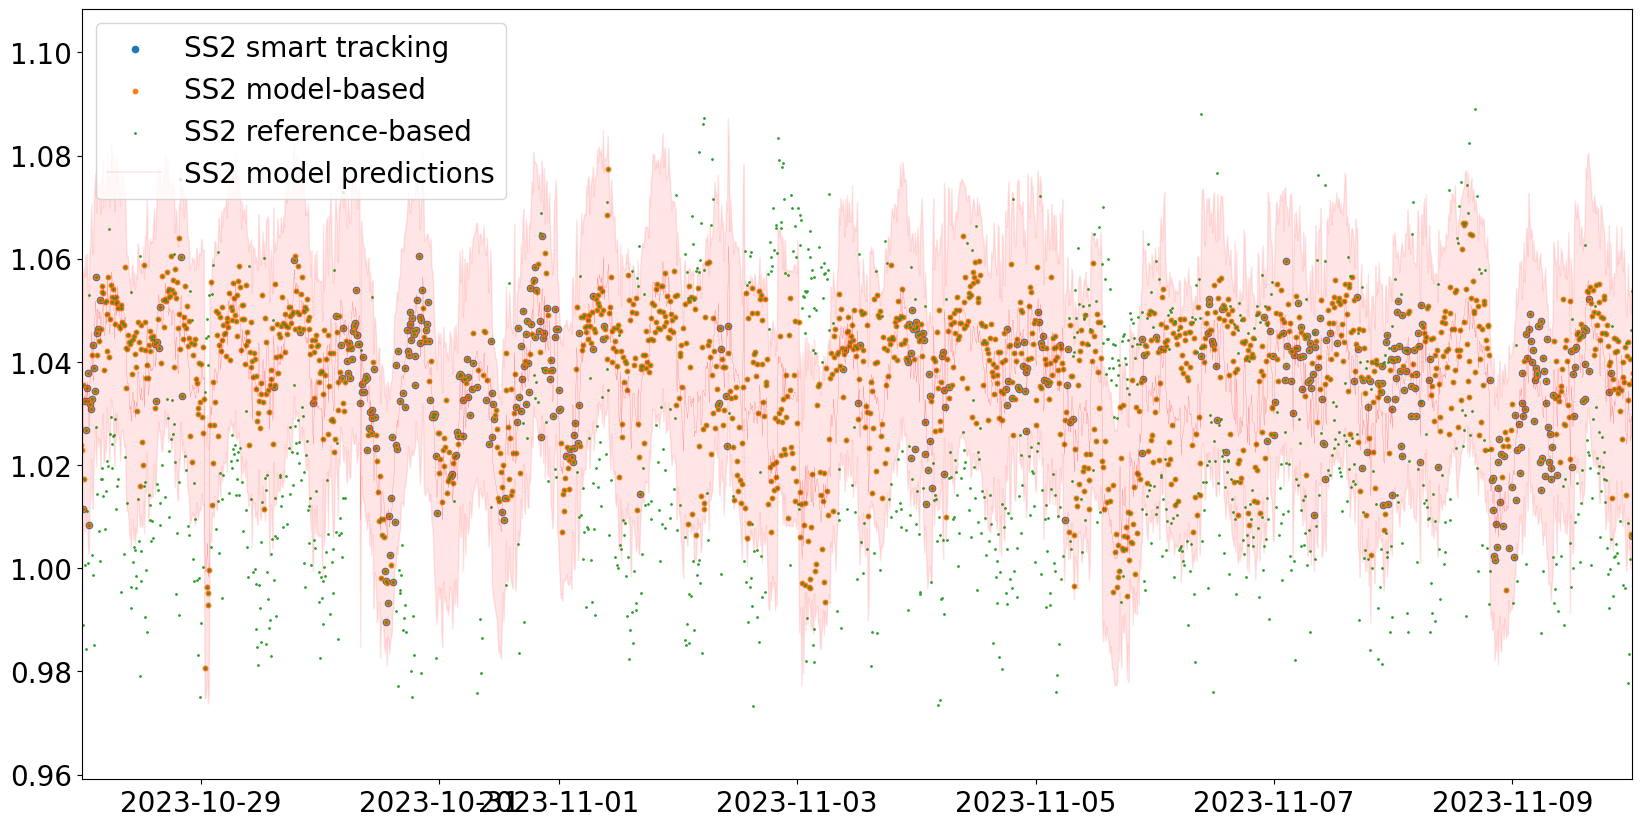

In [351]:
plt.figure(figsize=(20,10))
#plt.scatter(mpe_ss_data.index, mpe_ss_data['mean_frequency'], label='SS', s=1)
plt.scatter(ss2_smart_tracking.index, ss2_smart_tracking['frequency'], label='SS2 smart tracking', s=20)
plt.scatter(ss2_model_based.index, ss2_model_based['frequency'], label='SS2 model-based', s=10)
plt.scatter(ss2_reference_based.index, ss2_reference_based['mean_frequency'], label='SS2 reference-based', s=1)
plt.plot(predictions_df['predicted_frequency'], label='SS2 model predictions', color='red', linewidth=0.1)
plt.fill_between(predictions_df.index, predictions_df['predicted_frequency']-prediction_lim, predictions_df['predicted_frequency']+prediction_lim, alpha=0.1, color='red')
plt.xlim(datetime.datetime(2023, 10, 28, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 11,10, tzinfo=datetime.timezone.utc))
plt.legend(loc='upper left')

plt.show()
plt.close()

In [352]:
residual_reference_based = ss2_reference_based['mean_frequency'] - ss2_reference_based['mean_frequency'].mean()
residual_model_based = ss2_model_based['frequency'] - predictions_df['predicted_frequency']
residual_smart_tracking = ss2_smart_tracking['frequency'] - predictions_df['predicted_frequency']

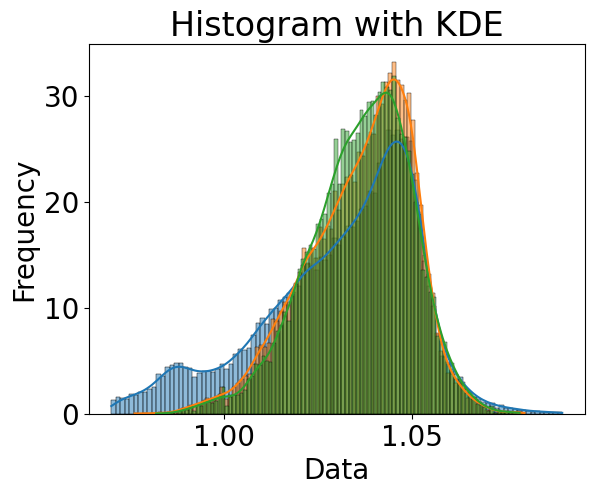

In [353]:
import seaborn as sns
sns.histplot(ss2_reference_based['mean_frequency'], bins=100, kde=True, stat='density')  # 'kde' adds a Kernel Density Estimate plot
sns.histplot(ss2_model_based['frequency'], bins=100, kde=True, stat='density')  # 'kde' adds a Kernel Density Estimate plot
sns.histplot(ss2_smart_tracking['frequency'], bins=100, kde=True, stat='density')  # 'kde' adds a Kernel Density Estimate plot
plt.title('Histogram with KDE')
plt.xlabel('Data')
plt.ylabel('Frequency')

plt.show()

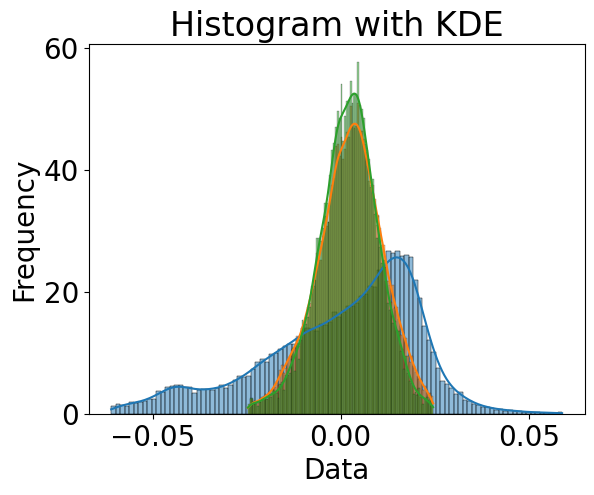

In [354]:
import seaborn as sns
sns.histplot(residual_reference_based, bins=100, kde=True, stat='density')  # 'kde' adds a Kernel Density Estimate plot
sns.histplot(residual_model_based, bins=100, kde=True, stat='density')  # 'kde' adds a Kernel Density Estimate plot
sns.histplot(residual_smart_tracking, bins=100, kde=True, stat='density')  # 'kde' adds a Kernel Density Estimate plot
plt.title('Histogram with KDE')
plt.xlabel('Data')
plt.ylabel('Frequency')

plt.show()

# Decision by month

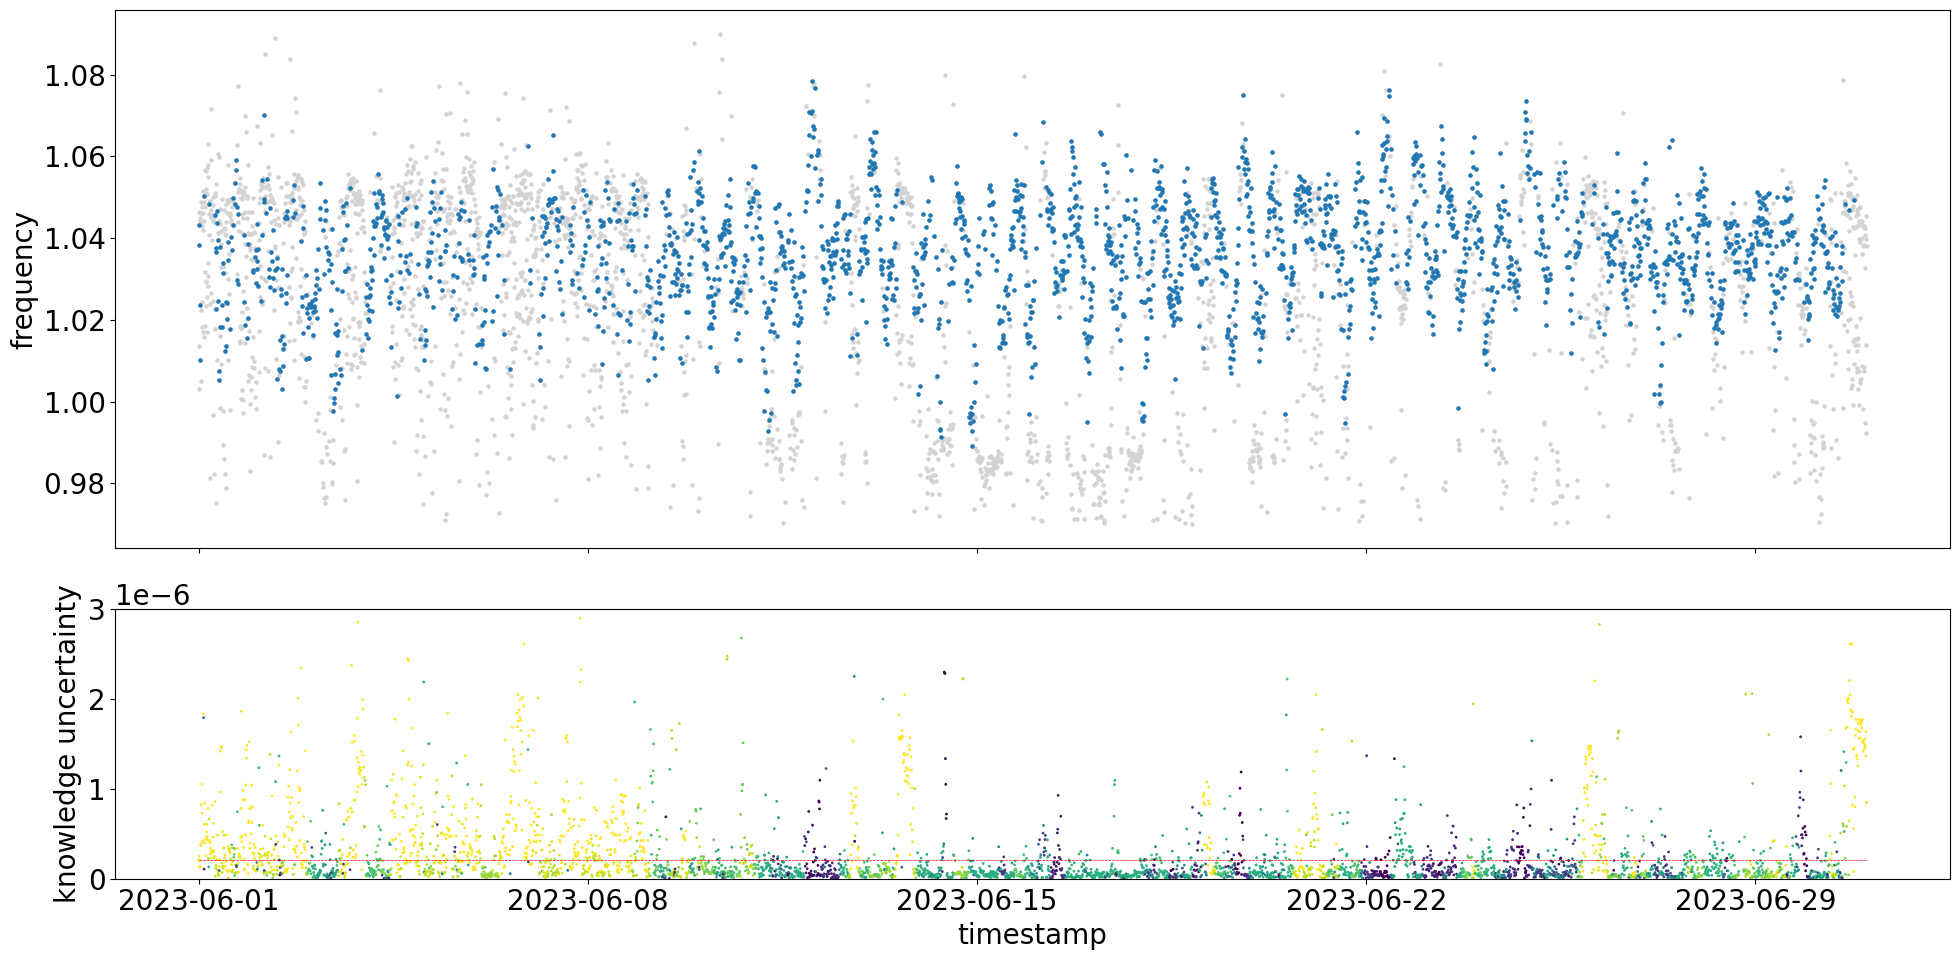

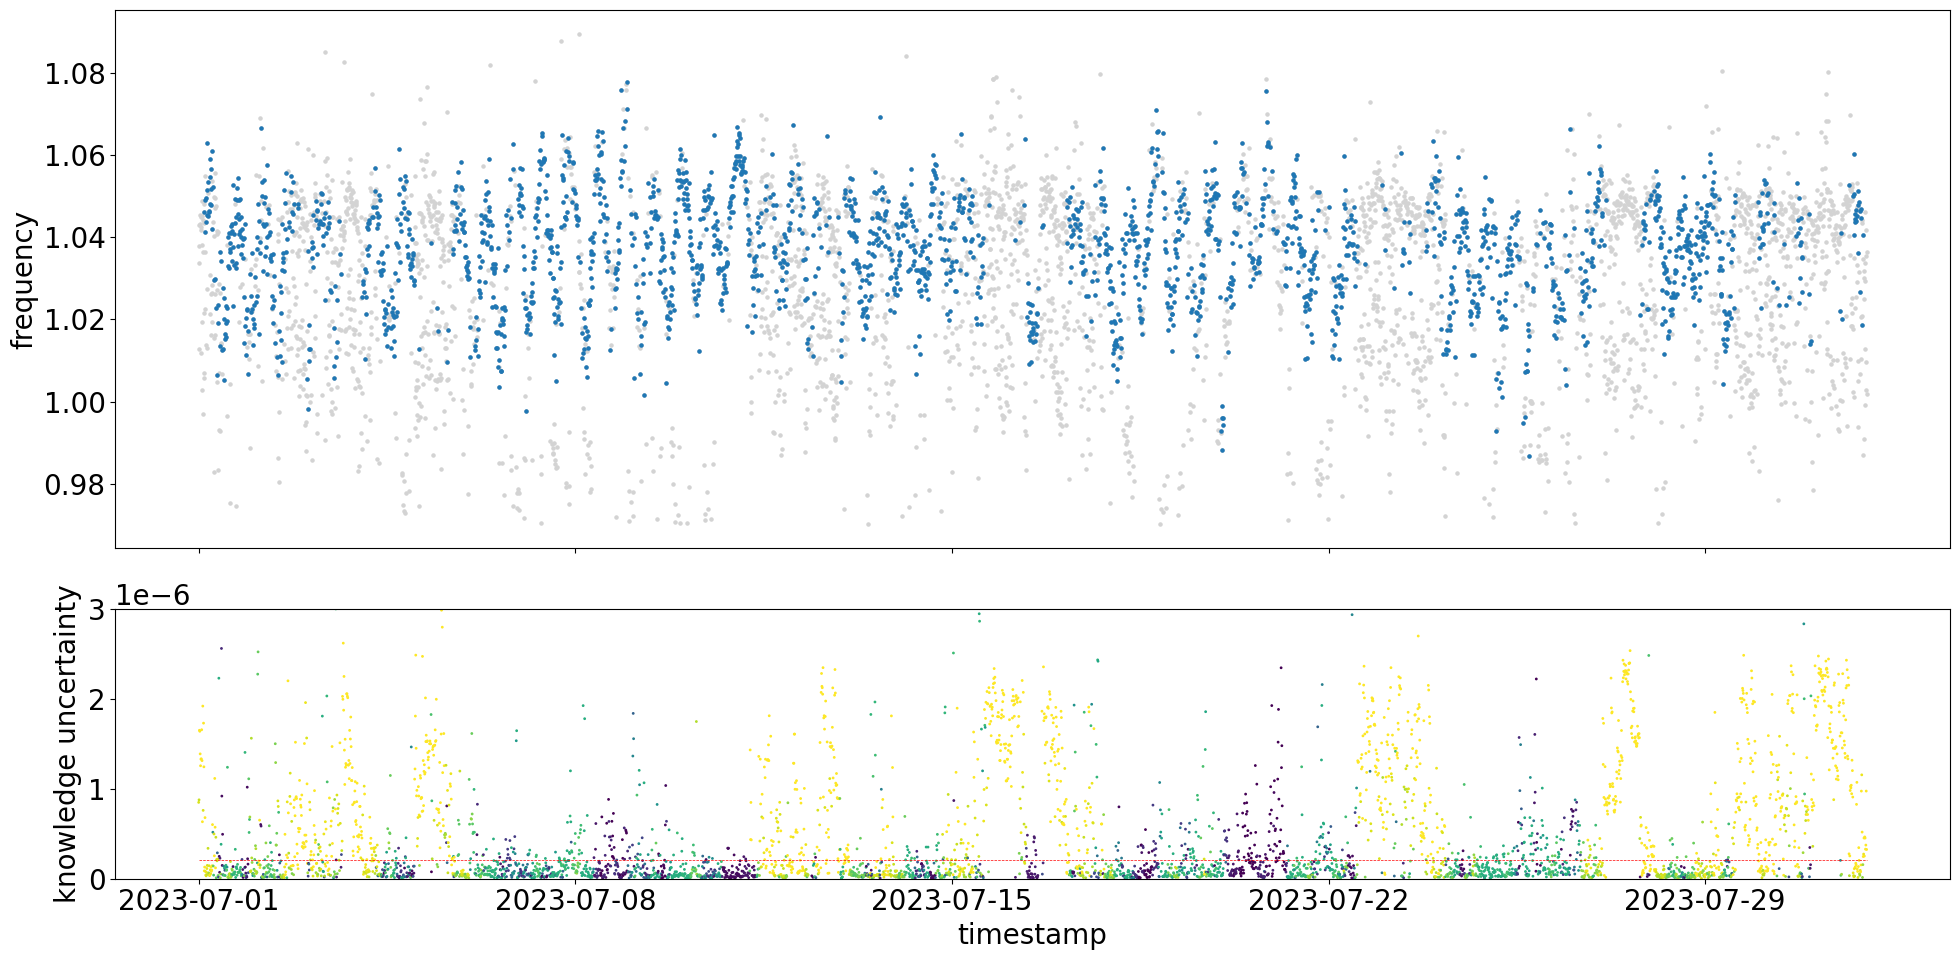

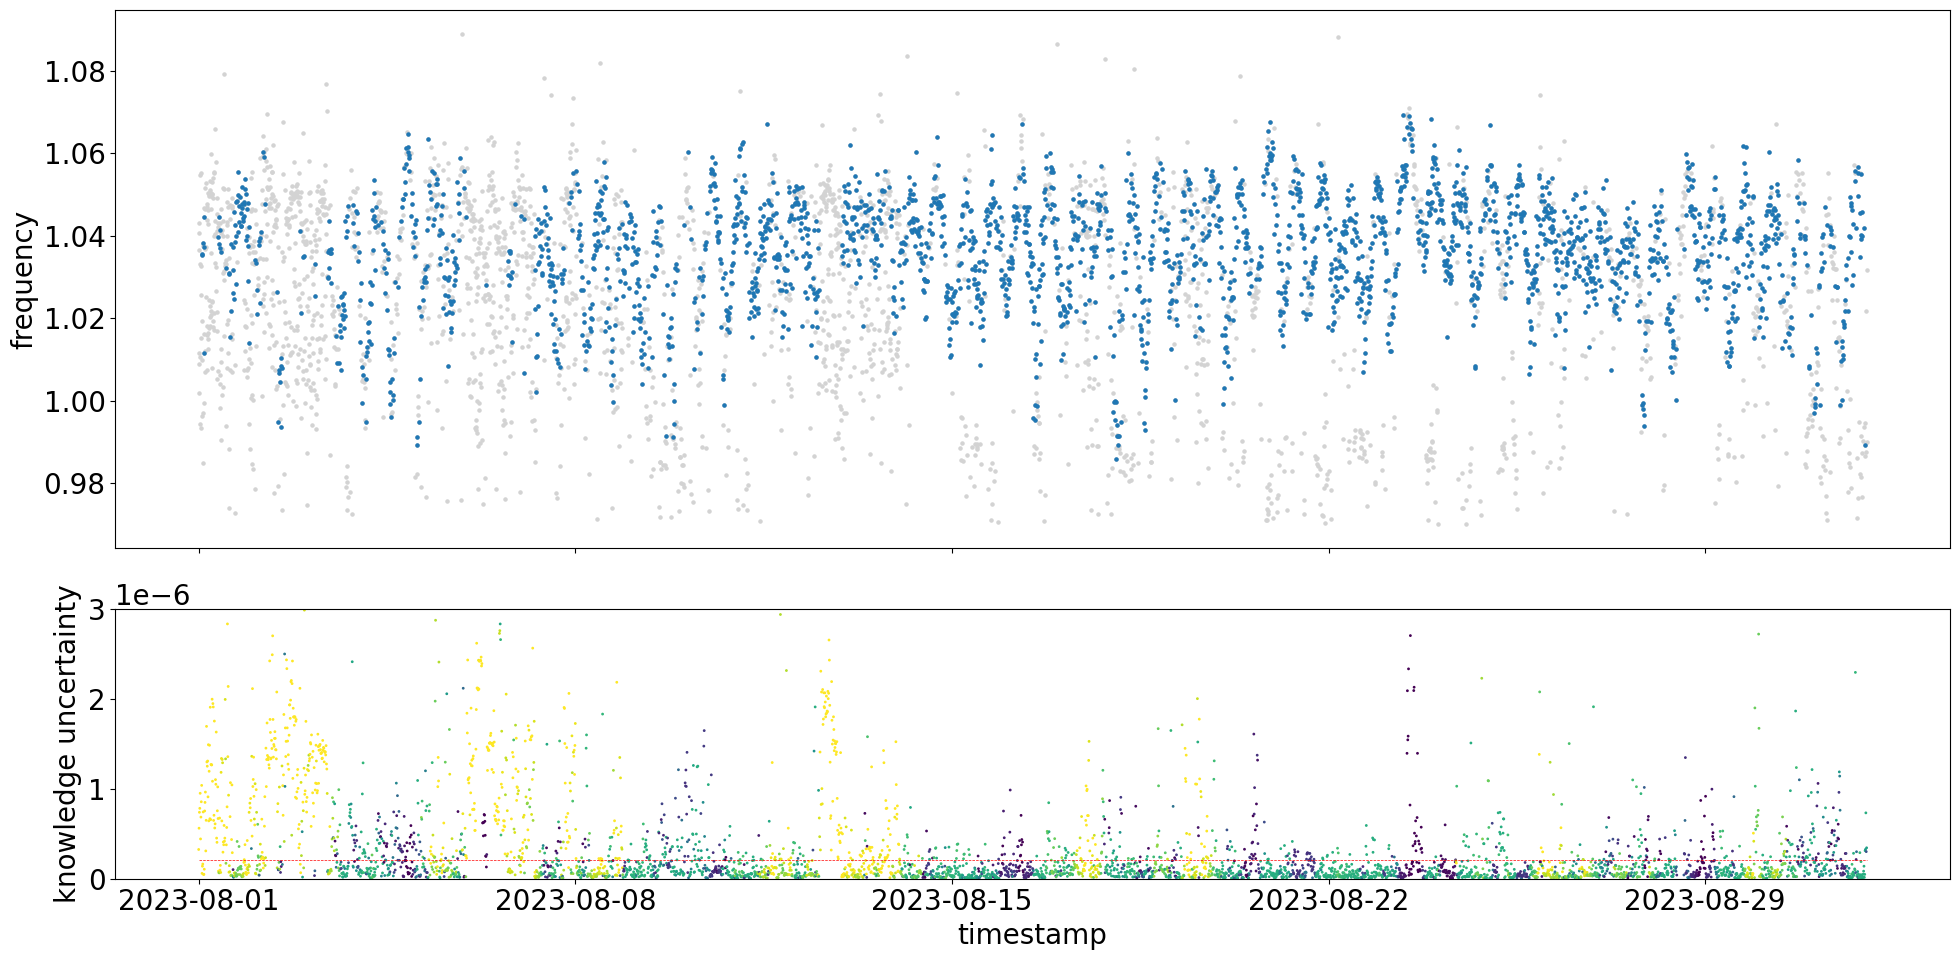

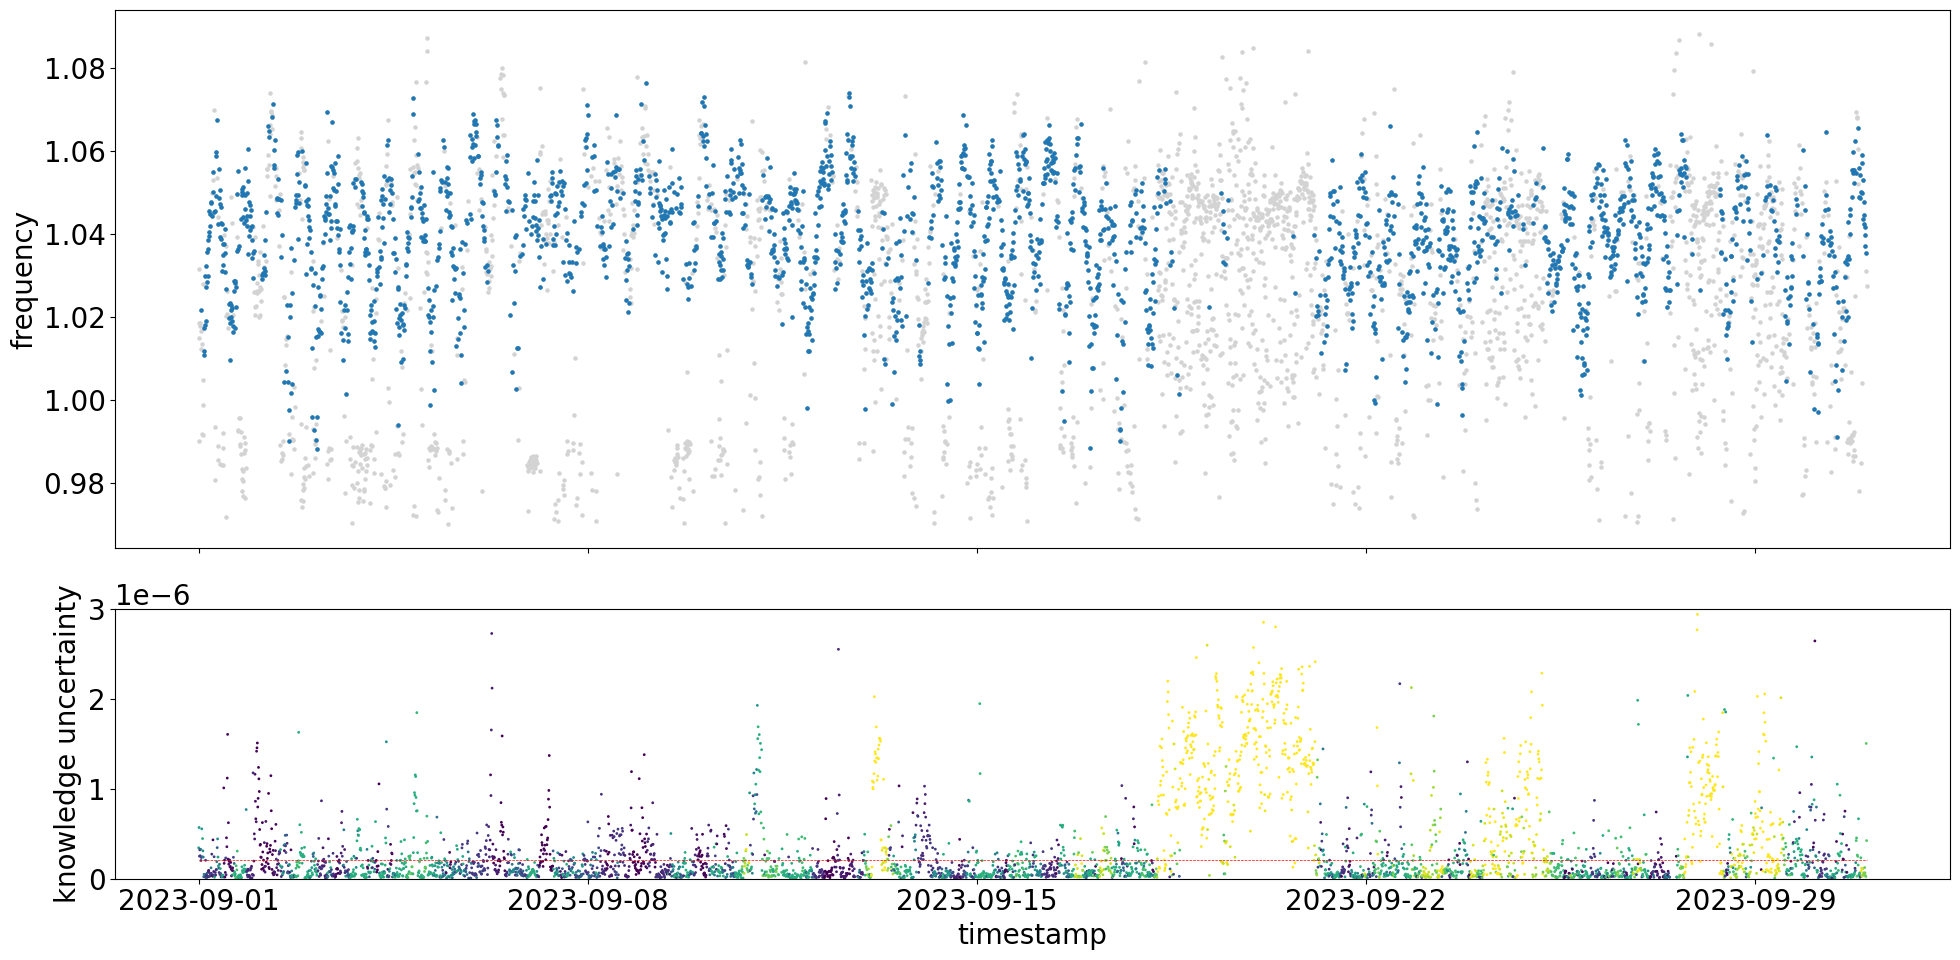

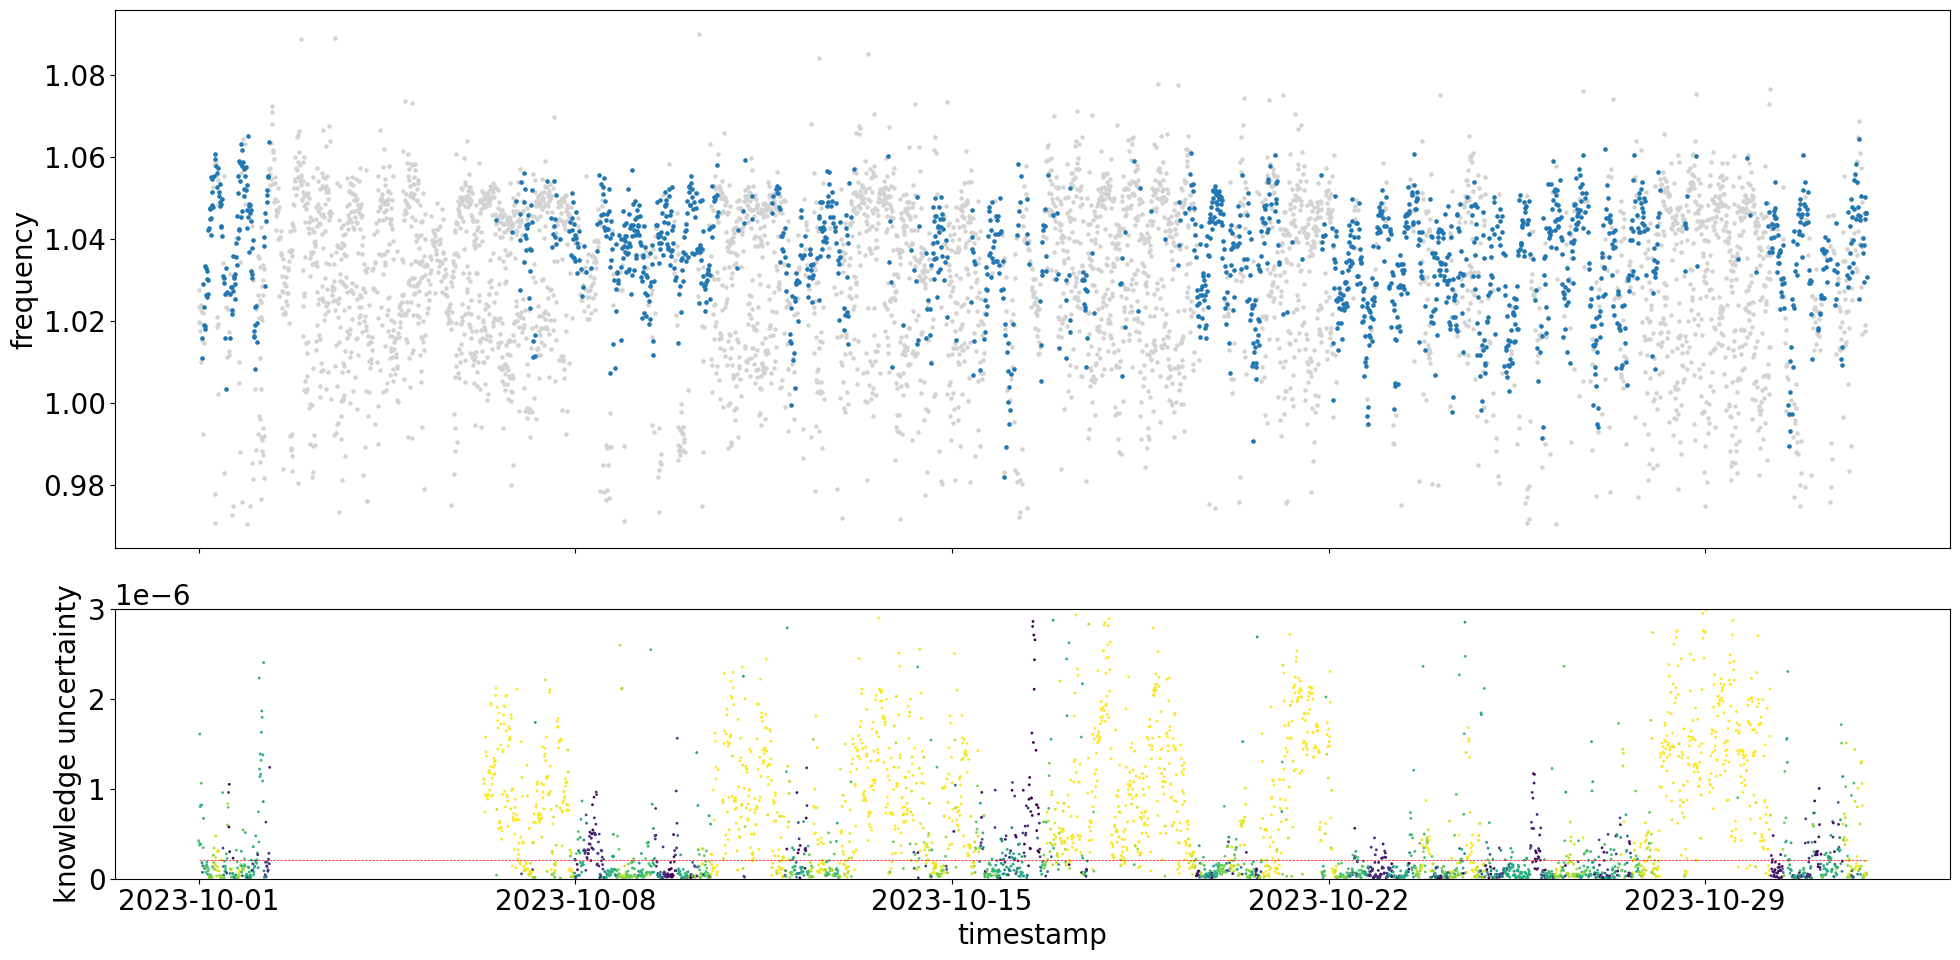

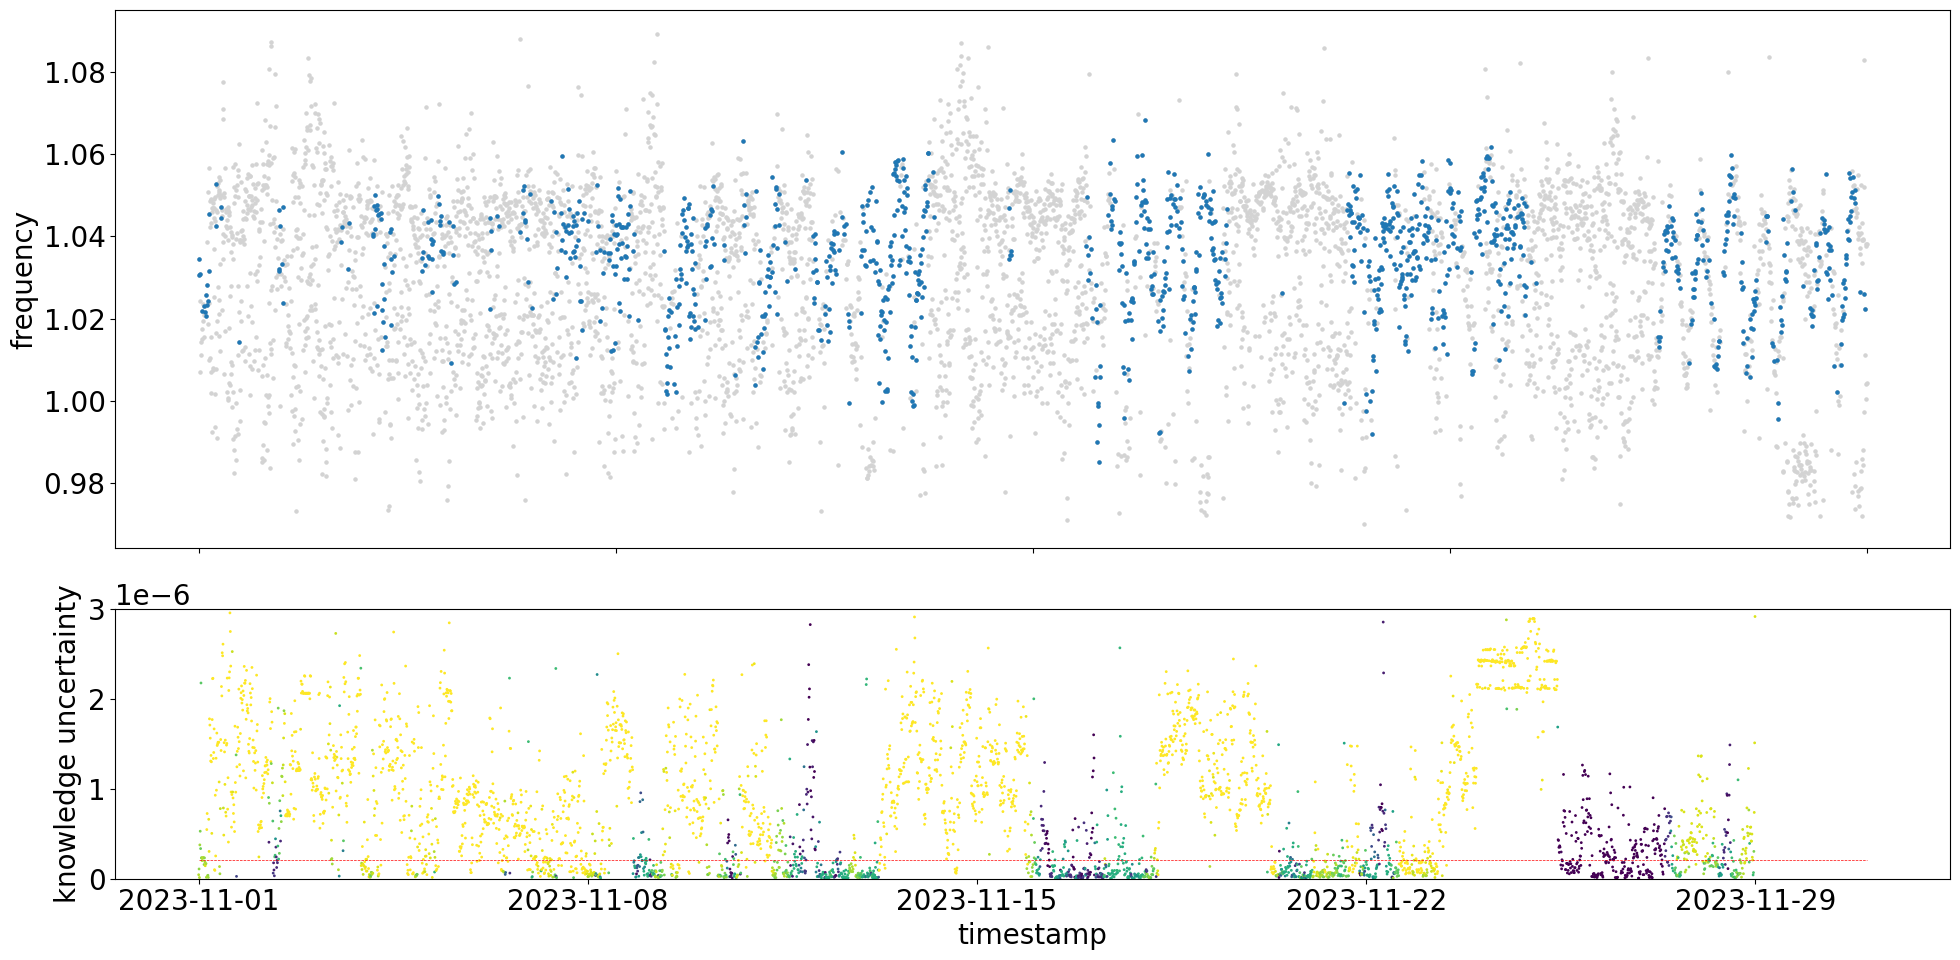

In [444]:
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
start = mpe_ss_data.index[0]
end  = mpe_ss_data.index[-1]

while start < end:
    intermediate = start + relativedelta(months=1)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [2, 1]})
    ax1.scatter(ss2_reference_based[start:intermediate].index, ss2_reference_based[start:intermediate]['mean_frequency'], label='SS2 reference-based', s=5, color='lightgrey')
    ax1.scatter(ss2_smart_tracking[start:intermediate].index, ss2_smart_tracking[start:intermediate]['frequency'], label='SS2 smart tracking', s=5)
    ax1.set_xlabel('')
    ax1.set_xticks(np.arange(start, intermediate, 7, dtype='datetime64[D]'))
    ax1.set_xticklabels(np.empty(len(np.arange(start, intermediate, 7, dtype='datetime64[D]')), dtype='U10'))
    ax2.scatter(
        predictions_virutal_ensemble[start:intermediate].index,
        predictions_virutal_ensemble[start:intermediate]['knowledge_uncertainty'],
        label='SS2 model predictions',
        c=X[start:intermediate]['mean_NW2_C02_rpm'],
        cmap = 'viridis',
        s=1)
    ax2.set_ylim(0, 3e-6)
    ax2.hlines(uncertainty_lim, start, intermediate, color='red', linewidth=0.5, linestyles='dashed')
    ax2.set_xlabel('timestamp')
    ax2.set_xticks(np.arange(start, intermediate, 7, dtype='datetime64[D]'))
    ax2.set_ylabel('knowledge uncertainty')
    ax1.set_ylabel('frequency')
    start = intermediate
    plt.tight_layout()
    plt.show()
    plt.close()


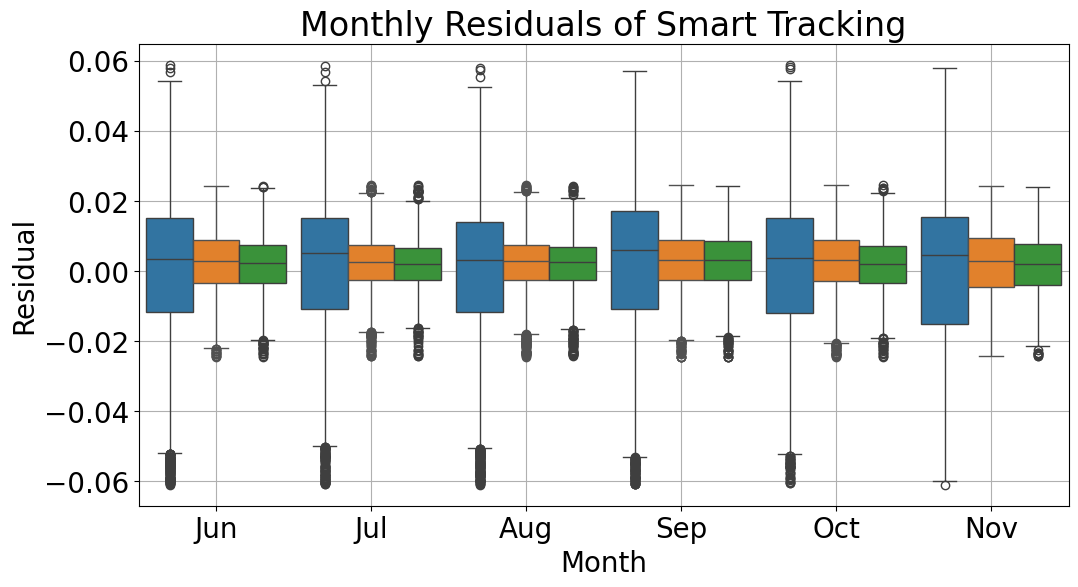

In [357]:
# Make a boxplot of residual_smart_tracking month by month on a pot with month in the x axis and the residual in the y axis


month_by_month_residual = pd.DataFrame()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nr_months = residual_reference_based.index.month.unique().shape[0]

# Assuming your DataFrame is named residual_smart_tracking
# and has columns 'date' (datetime) and 'residual' (numeric)
residual_smart_tracking_df = pd.DataFrame(residual_smart_tracking, columns=['residual'])
residual_model_based_df = pd.DataFrame(residual_model_based, columns=['residual'])
residual_reference_based_df = pd.DataFrame(residual_reference_based, columns=['mean_frequency'])
# Extract the month from the date
residual_smart_tracking_df['month'] = residual_smart_tracking_df.index.month
residual_model_based_df['month'] = residual_model_based_df.index.month
residual_reference_based_df['month'] = residual_reference_based.index.month

# Define positions for the boxplots
positions1 = [x - 0.3 for x in range(0, nr_months)]  # slightly left
positions2 = [x for x in range(0, nr_months)]  # center
positions3 = [x + 0.3 for x in range(0, nr_months)]  # slightly right


# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='mean_frequency', data=residual_reference_based_df, width=0.3, positions=positions1)
sns.boxplot(x='month', y='residual', data=residual_model_based_df, width=0.3, positions=positions2)
sns.boxplot(x='month', y='residual', data=residual_smart_tracking_df, width=0.3, positions=positions3)

plt.title('Monthly Residuals of Smart Tracking')
plt.xlabel('Month')
plt.ylabel('Residual')
plt.xticks(ticks=range(0, nr_months), labels=['Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
plt.grid(True)
#plt.ylim(-0.01, 0.01)
plt.show()

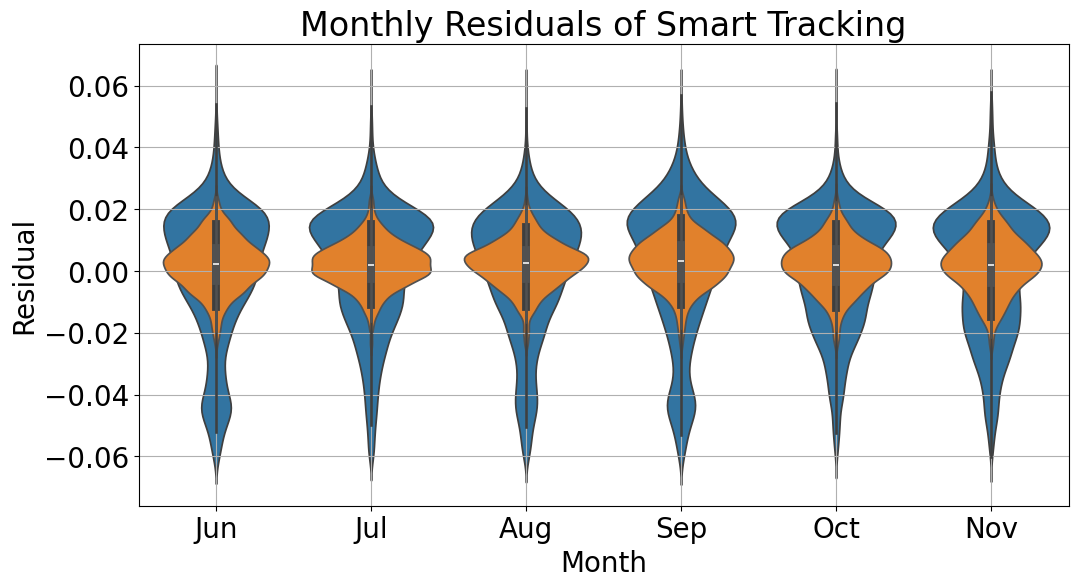

In [358]:
# Make a boxplot of residual_smart_tracking month by month on a pot with month in the x axis and the residual in the y axis


month_by_month_residual = pd.DataFrame()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nr_months = residual_reference_based.index.month.unique().shape[0]

# Assuming your DataFrame is named residual_smart_tracking
# and has columns 'date' (datetime) and 'residual' (numeric)
residual_smart_tracking_df = pd.DataFrame(residual_smart_tracking, columns=['residual'])
# Extract the month from the date
residual_smart_tracking_df['month'] = residual_smart_tracking_df.index.month
residual_smart_tracking_df.dropna(inplace=True)
# Plot
plt.figure(figsize=(12, 6))

sns.violinplot(x='month', y='mean_frequency', data=residual_reference_based_df)
#sns.violinplot(x='month', y='residual', data=residual_model_based_df)
sns.violinplot(x='month', y='residual', data=residual_smart_tracking_df)


plt.title('Monthly Residuals of Smart Tracking')
plt.xlabel('Month')
plt.ylabel('Residual')
plt.xticks(ticks=range(0, nr_months), labels=['Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
plt.grid(True)
#plt.ylim(-0.01, 0.01)
plt.show()
plt.close()


In [359]:
month_counts

count
month       
6       2133
7       2157
8       2394
9       1983
10      1455
11       987

In [360]:
range(month_counts.index.min(), residual_smart_tracking_df['month'].nunique()+month_counts.index.min())

range(6, 12)

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\1222743722.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['','', '', '', '', ''])


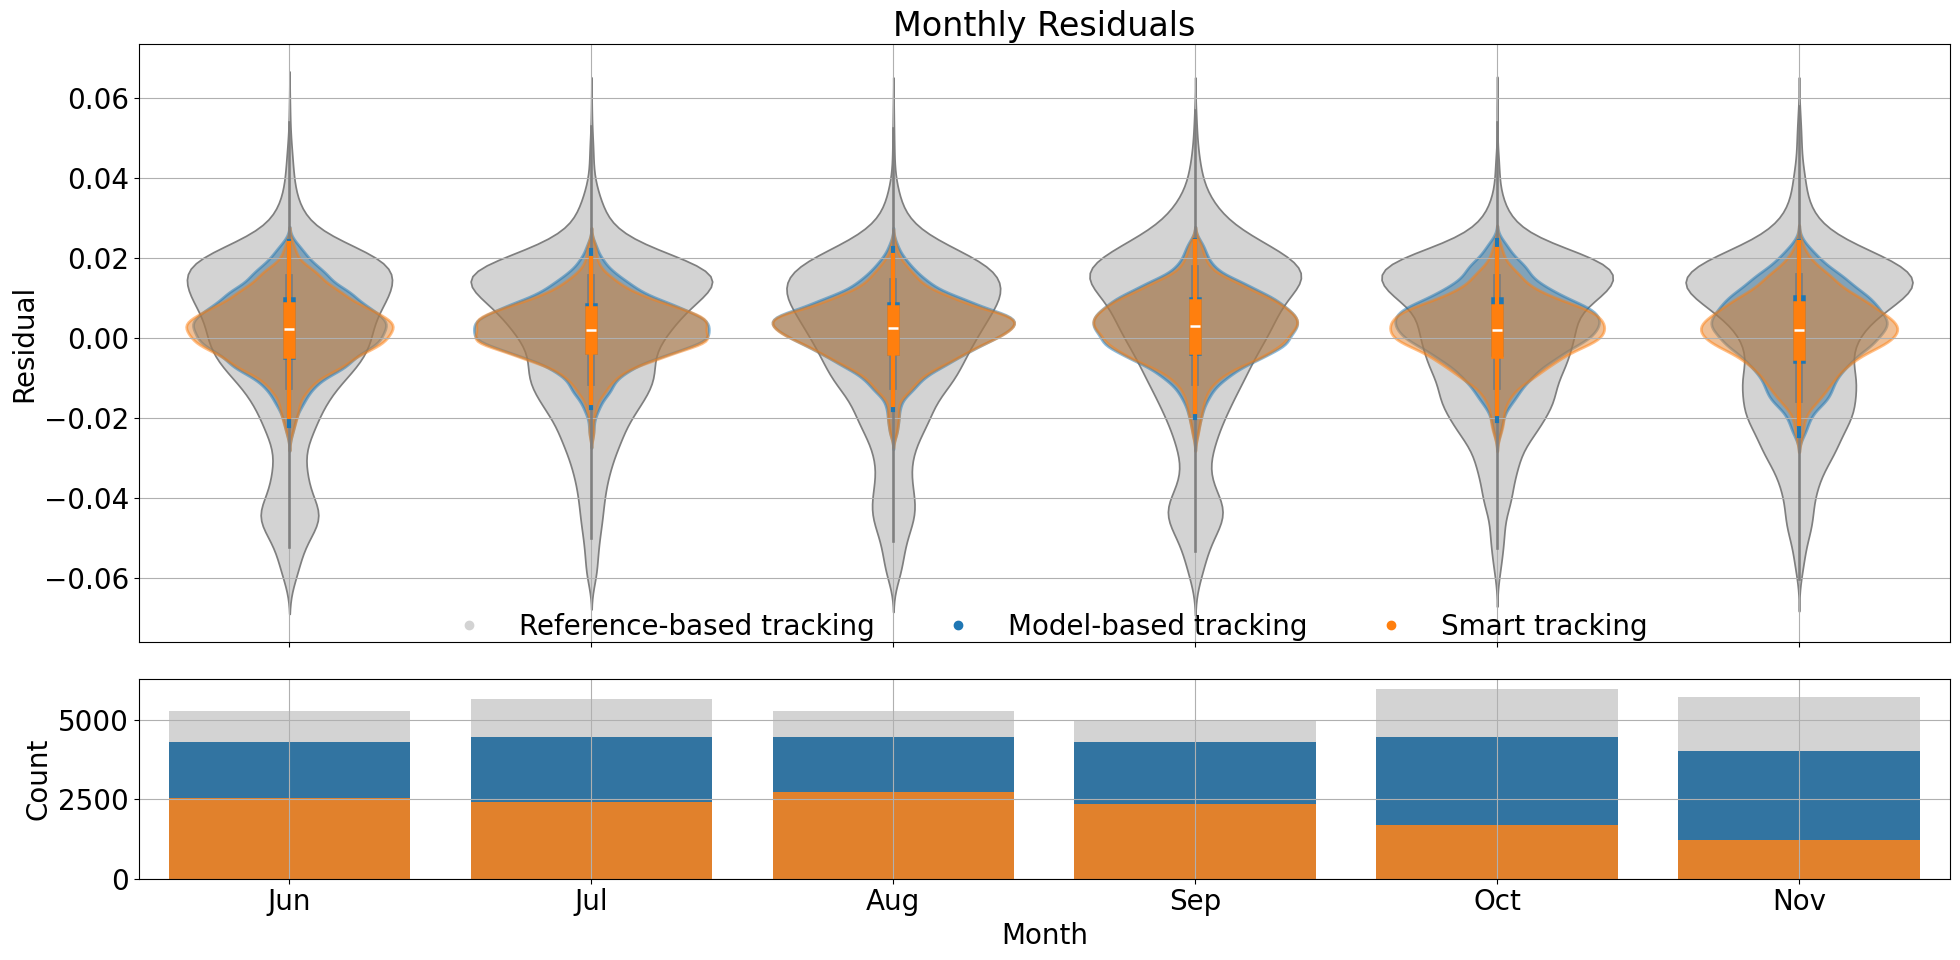

In [376]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named residual_smart_tracking
# and has columns 'date' (datetime) and 'residual' (numeric)
residual_smart_tracking_df = pd.DataFrame(residual_smart_tracking, columns=['residual'])
residual_smart_tracking_df['month'] = residual_smart_tracking_df.index.month
residual_smart_tracking_df.dropna(inplace=True)

# Count data points for each month
month_counts = pd.DataFrame(residual_smart_tracking_df['month'].value_counts().sort_index())
month_counts_model_based = pd.DataFrame(residual_model_based_df['month'].value_counts().sort_index())
month_counts_total = pd.DataFrame(residual_reference_based_df['month'].value_counts().sort_index())
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]})

# Violin plot on the first subplot
sns.violinplot(x='month', y='mean_frequency', data=residual_reference_based_df, ax=ax1, color='lightgrey', label='Reference-based tracking')
sns.violinplot(x='month', y='residual', data=residual_model_based_df, ax=ax1, color='tab:blue', label='Model-based tracking',   alpha=0.5, edgecolor='tab:blue', linewidth=2)

sns.violinplot(x='month', y='residual', data=residual_smart_tracking_df, ax=ax1, color='tab:orange', label='Smart tracking',  alpha=0.5, edgecolor='tab:orange', linewidth=2)
ax1.set_title('Monthly Residuals')
ax1.set_ylabel('Residual')
ax1.set_xlabel('')
#ax1.set_xticks(range(0, residual_smart_tracking_df['month'].nunique()))
ax1.set_xticklabels(['','', '', '', '', ''])
ax1.grid(True)
# Create a custom legend
custom_colors = ['lightgrey', 'tab:blue','tab:orange']  # Define your colors here
custom_handles = [plt.Line2D([], [], marker='o', linestyle='', color=color) for color in custom_colors]
ax1.legend(custom_handles, ['Reference-based tracking', 'Model-based tracking', 'Smart tracking'], loc='lower center', frameon=False, bbox_to_anchor=(0.5, -0.04), ncol=3)

# Bar chart on the second subplot
sns.barplot(x='month', y='count', data=month_counts_total, ax=ax2, color='lightgrey')
sns.barplot(x='month', y='count', data=month_counts_model_based, ax=ax2, color='tab:blue')
sns.barplot(x='month', y='count', data=month_counts, ax=ax2, color='tab:orange')
ax2.set_xlabel('Month')
ax2.set_ylabel('Count')
ax2.set_xticks(range(0, residual_smart_tracking_df['month'].nunique()))
ax2.set_xticklabels(['Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
ax2.grid(True)

# Show plot
plt.tight_layout()
plt.show()


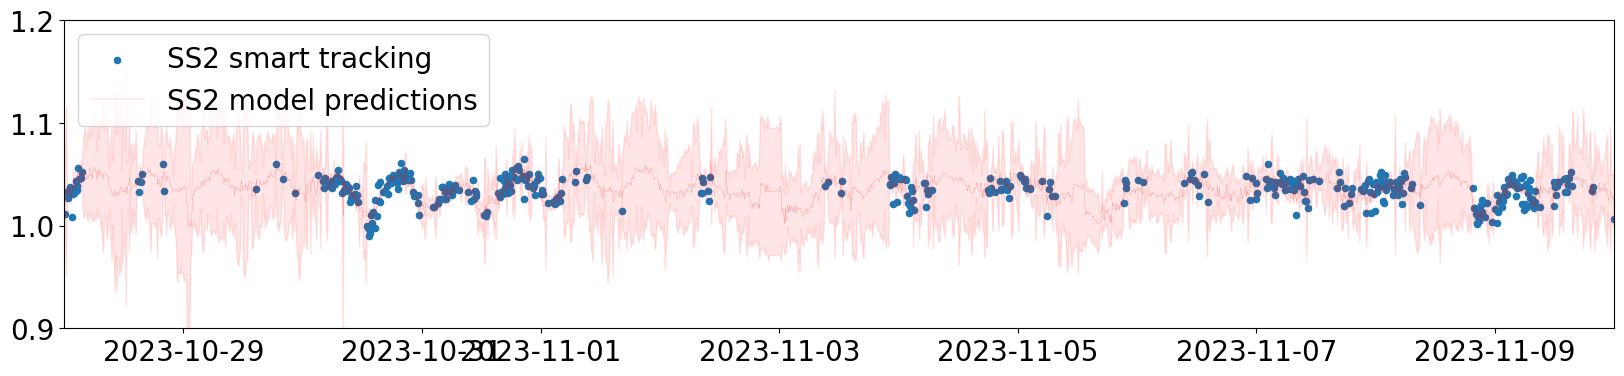

(19658.0, 19671.0)

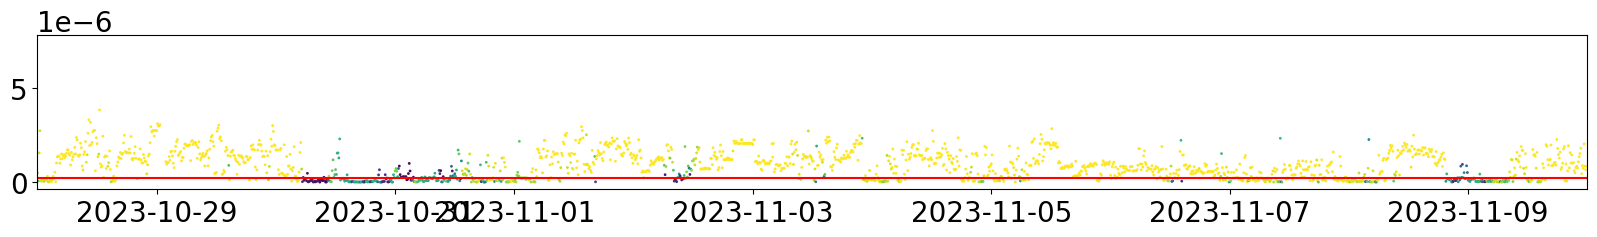

In [362]:
plt.figure(figsize=(20,4))
#plt.scatter(mpe_ss_data.index, mpe_ss_data['mean_frequency'], label='SS', s=1)
plt.scatter(ss2_smart_tracking.index, ss2_smart_tracking['frequency'], label='SS2 smart tracking', s=20)
#plt.scatter(ss2_model_based.index, ss2_model_based['frequency'], label='SS2 model-based', s=10)
#plt.scatter(ss2_reference_based.index, ss2_reference_based['mean_frequency'], label='SS2 reference-based', s=1)
plt.plot(predictions_df['predicted_frequency'], label='SS2 model predictions', color='red', linewidth=0.1)
plt.fill_between(predictions_df.index, predictions_df['predicted_frequency']-predictions_virutal_ensemble['knowledge_uncertainty']*3e4, predictions_df['predicted_frequency']+3e4*predictions_virutal_ensemble['knowledge_uncertainty'], alpha=0.1, color='red')
plt.xlim(datetime.datetime(2023, 10, 28, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 11,10, tzinfo=datetime.timezone.utc))
plt.legend(loc='upper left')
plt.ylim(0.9, 1.2)
plt.show()
plt.close()
plt.figure(figsize=(20,2))
plt.scatter(predictions_virutal_ensemble.index, predictions_virutal_ensemble['knowledge_uncertainty'], c= X.filter(regex='rpm').values[:,0],s=1)
plt.hlines(uncertainty_lim, predictions_virutal_ensemble.index.min(), predictions_virutal_ensemble.index.max(), color='red')
plt.xlim(datetime.datetime(2023, 10, 28, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 11,10, tzinfo=datetime.timezone.utc))


In [363]:
new_caseID_folder = os.path.join(data_folder, 'interim', 'nw2', 'labeled')
case_IDs = pd.read_csv(os.path.join(new_caseID_folder, 'caseIDs_Alexandra', loc+turbine+'_caseIDs.csv'))
case_IDs['timestamp'] = pd.to_datetime(case_IDs['timestamp'], utc=True)
case_IDs.set_index('timestamp', inplace=True)

In [364]:
common_indices_X_case = case_IDs.index.intersection(X.index)

In [365]:
case_IDs

caseID
timestamp                                                                   
2022-10-01 00:00:00+00:00                                                NaN
2022-10-01 00:10:00+00:00       Rated power: Turbine at rated power (9525kW)
2022-10-01 00:20:00+00:00       Rated power: Turbine at rated power (9525kW)
2022-10-01 00:30:00+00:00       Rated power: Turbine at rated power (9525kW)
2022-10-01 00:40:00+00:00       Rated power: Turbine at rated power (9525kW)
...                                                                      ...
2023-11-30 23:20:00+00:00  Curtailed (All): Catchall for data points that...
2023-11-30 23:30:00+00:00  Curtailed (All): Catchall for data points that...
2023-11-30 23:40:00+00:00          rpm<Max: Turbine speeding up to rated RPM
2023-11-30 23:50:00+00:00                rpm6.6: Turbine rotating at 6.6 RPM
2023-12-01 00:00:00+00:00          rpm<Max: Turbine speeding up to rated RPM

[61292 rows x 1 columns]

In [384]:
case_IDs['caseID'].unique()[0]

nan

In [404]:
cases = [
    'parked: Turbine parked, pitched at >87, rotating at less than 0.4RPM',
    'pitch:78: Turbine pitched at 78deg.',
    'idling: Generic idling (no constraint on pitch)',
    'cutin: Turbine speeding up to operational speeds',
    'cutin (pitch > 20): Turbine speeding up to operational speeds',
    'rpm<6.6: Turbine rotating up to 6.6RPM',
    'rpm6.6: Turbine rotating at 6.6 RPM',
    'Rated power: Turbine at rated power (9525kW)',
    'rpm<Max: Turbine speeding up to rated RPM',
    'Rated RPM: Turbine rotating at 10.4rpm or 10.445rpm',
    'High wind: Turbine reducing output power at extreme wind speeds',
    'Curtailed (All): Catchall for data points that fall out of the normal behaviour',
    'Missing SCADA: SCADA required to define cases is (partially) missing',
    np.nan
    ]
palette = [
    'limegreen',
    'chartreuse',
    'forestgreen',
    'mediumseagreen',
    'springgreen',
    'teal',
    'gold',
    'firebrick',
    'tomato',
    'peru',
    'purple',
    'dodgerblue',
    'black',
    'grey'
    ]
case_IDs['case_color'] = case_IDs['caseID'].apply(lambda x: palette[cases.index(x)])

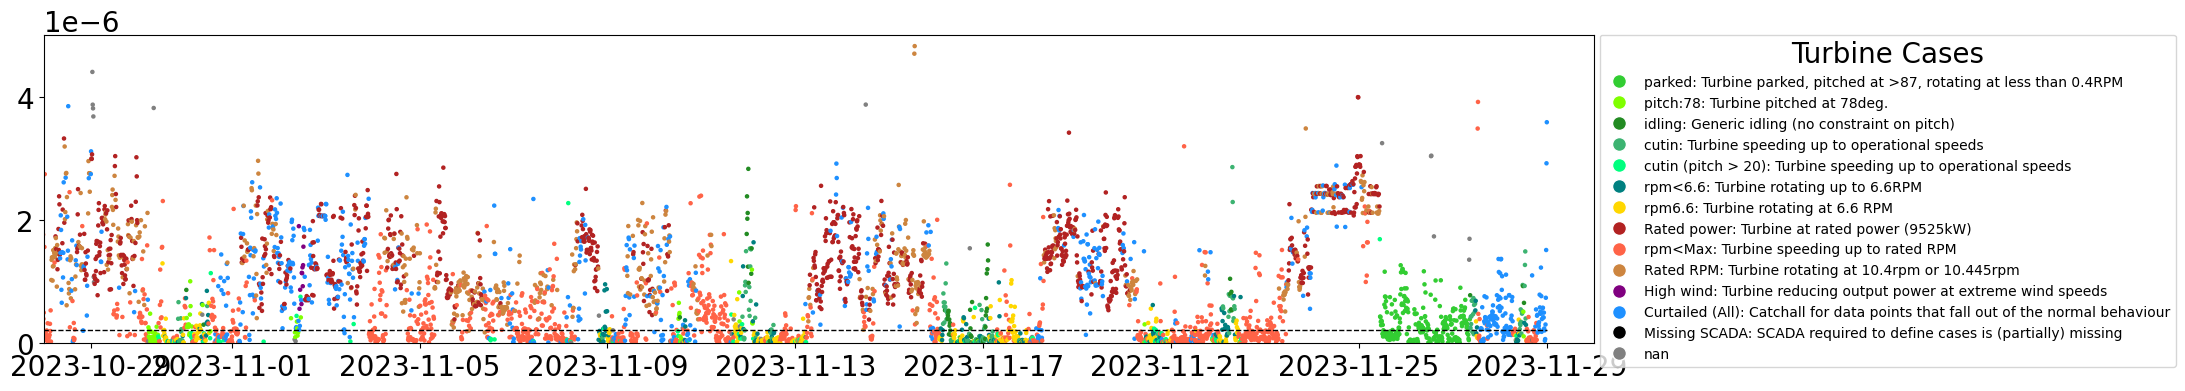

In [407]:
case_IDs_plot = case_IDs.loc[common_indices_X_case]
categories = case_IDs_plot['caseID'].unique()


predictions_virutal_ensemble_plot = predictions_virutal_ensemble.loc[common_indices_X_case]
df_ = pd.concat([predictions_virutal_ensemble_plot,case_IDs_plot], axis=1)
plt.figure(figsize=(20,4))
plt.scatter(df_.index, df_['knowledge_uncertainty'], c= df_['case_color'],s=5)
#plt.scatter(predictions_virutal_ensemble_plot.index, predictions_virutal_ensemble_plot['knowledge_uncertainty'], c= case_IDs_plot,s=1)
plt.hlines(uncertainty_lim, predictions_virutal_ensemble.index.min(), predictions_virutal_ensemble.index.max(), color='k', linestyles='dashed', linewidth=1)
plt.xlim(datetime.datetime(2023, 10, 28, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 11,30, tzinfo=datetime.timezone.utc))

# Create custom handles for the legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=case,
                             markerfacecolor=color, markersize=10) for case, color in zip(cases, palette)]

# Create custom legend
plt.legend(handles=legend_handles, title="Turbine Cases", fontsize=10, loc='upper right', bbox_to_anchor=(1.38, 1.025))
plt.ylim(0, 5e-6)
plt.show()

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3764261391.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handles in legend.legendHandles:


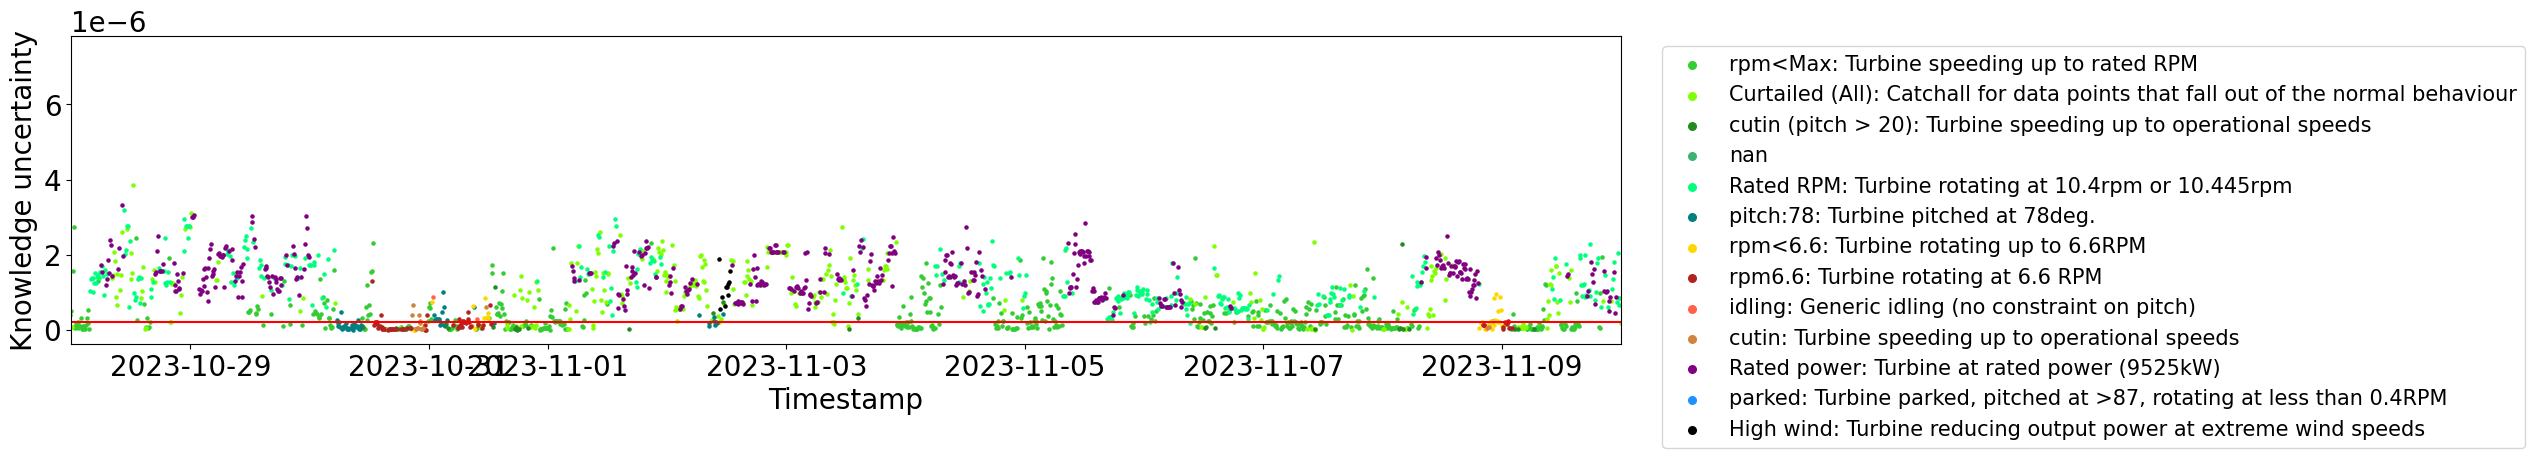

In [377]:
import matplotlib.pyplot as plt
import pandas as pd

case_IDs_plot = case_IDs.loc[common_indices_X_case]
categories = case_IDs_plot['caseID'].unique()
palette = sns.color_palette("tab20", n_colors=len(categories))
color_map = dict(zip(categories, palette))
predictions_virutal_ensemble_plot = predictions_virutal_ensemble.loc[common_indices_X_case]
df_ = pd.concat([predictions_virutal_ensemble_plot,case_IDs_plot], axis=1)

# Create a color palette with the tab20 colormap
palette = ['limegreen',
 'chartreuse',
 'forestgreen',
 'mediumseagreen',
 'springgreen',
 'teal',
 'gold',
 'firebrick',
 'tomato',
 'peru',
 'purple',
 'dodgerblue',
 'black']
color_map = {category: palette[i % len(palette)] for i, category in enumerate(categories)}

# Create scatter plot
plt.figure(figsize=(20, 4))

for category, color in color_map.items():
    subset = df_[df_['caseID'] == category]
    plt.scatter(subset.index, subset['knowledge_uncertainty'], label=category, color=color, s=5)

# Adding legend and labels
plt.xlabel('Timestamp')
plt.ylabel('Knowledge uncertainty')
legend = plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=15)
for handles in legend.legendHandles:
    handles.set_sizes([30.0])
plt.hlines(uncertainty_lim, predictions_virutal_ensemble.index.min(), predictions_virutal_ensemble.index.max(), color='red')

plt.xlim(datetime.datetime(2023, 10, 28, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 11,10, tzinfo=datetime.timezone.utc))
# Show plot
plt.show()

In [408]:
palette = [
    'limegreen',
    'chartreuse',
    'forestgreen',
    'mediumseagreen',
    'springgreen',
    'teal',
    'gold',
    'firebrick',
    'tomato',
    'peru',
    'purple',
    'dodgerblue',
    'black',
    'grey'
    ]

In [ ]:
case_IDs_plot = case_IDs.loc[common_indices_X_case]
categories = case_IDs_plot['caseID'].unique()


predictions_virutal_ensemble_plot = predictions_virutal_ensemble.loc[common_indices_X_case]
df_ = pd.concat([predictions_virutal_ensemble_plot,case_IDs_plot], axis=1)
plt.figure(figsize=(20,4))
plt.scatter(df_.index, df_['knowledge_uncertainty'], c= df_['case_color'],s=5)
#plt.scatter(predictions_virutal_ensemble_plot.index, predictions_virutal_ensemble_plot['knowledge_uncertainty'], c= case_IDs_plot,s=1)
plt.hlines(uncertainty_lim, predictions_virutal_ensemble.index.min(), predictions_virutal_ensemble.index.max(), color='k', linestyles='dashed', linewidth=1)
plt.xlim(datetime.datetime(2023, 10, 28, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 11,30, tzinfo=datetime.timezone.utc))

# Create custom handles for the legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=case,
                             markerfacecolor=color, markersize=10) for case, color in zip(cases, palette)]

# Create custom legend
plt.legend(handles=legend_handles, title="Turbine Cases", fontsize=10, loc='upper right', bbox_to_anchor=(1.38, 1.025))
plt.ylim(0, 5e-6)
plt.show()

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)


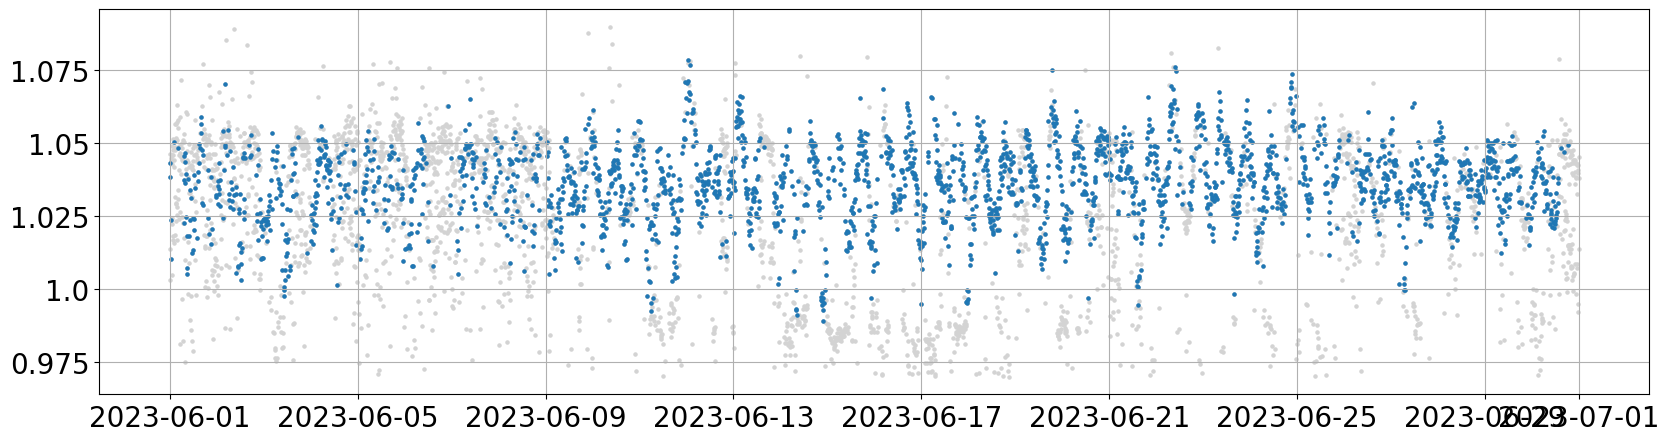

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)


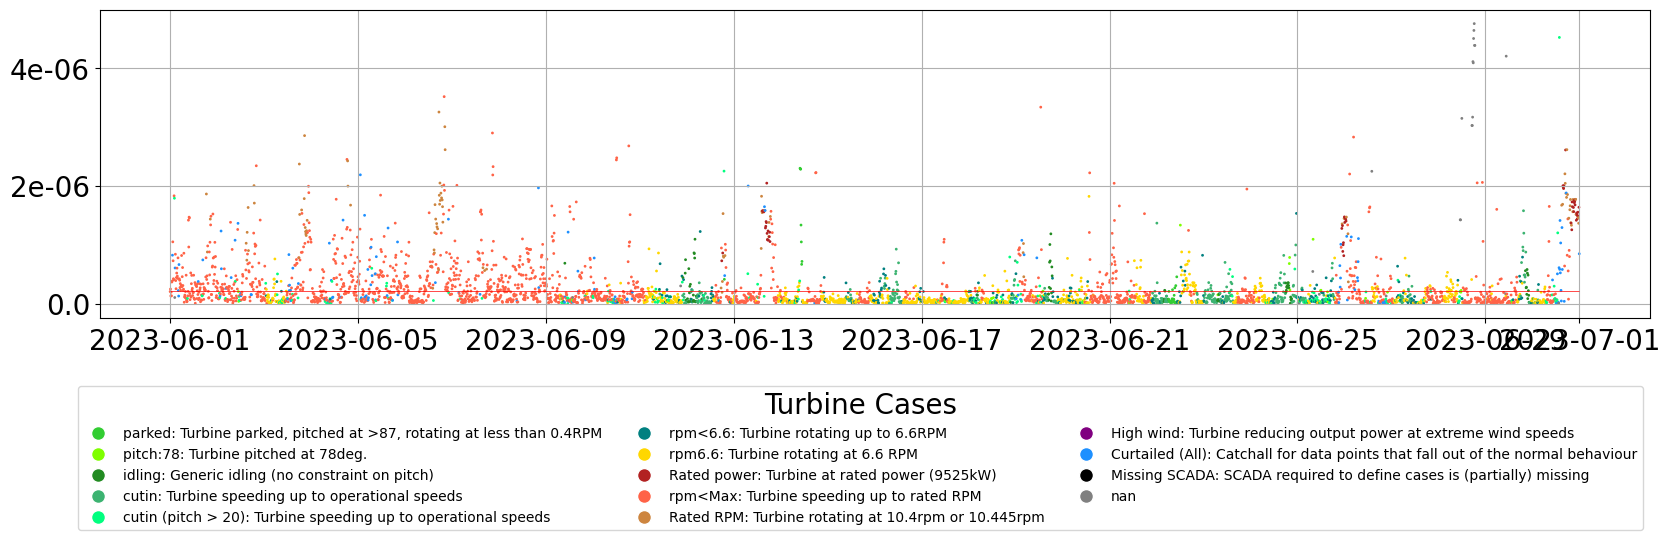

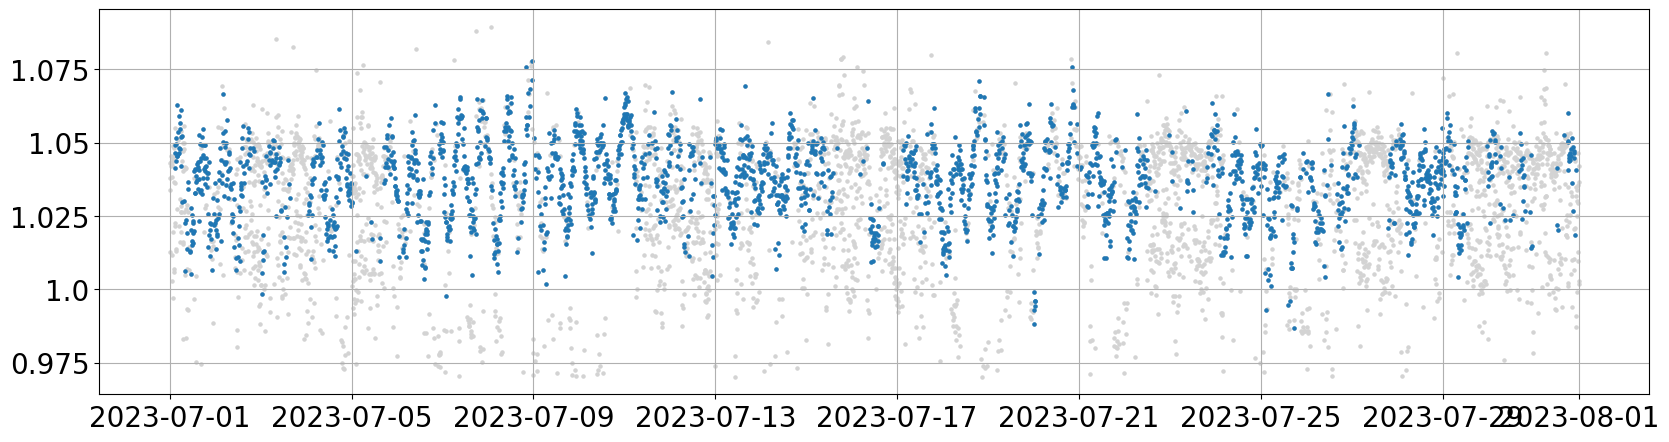

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)


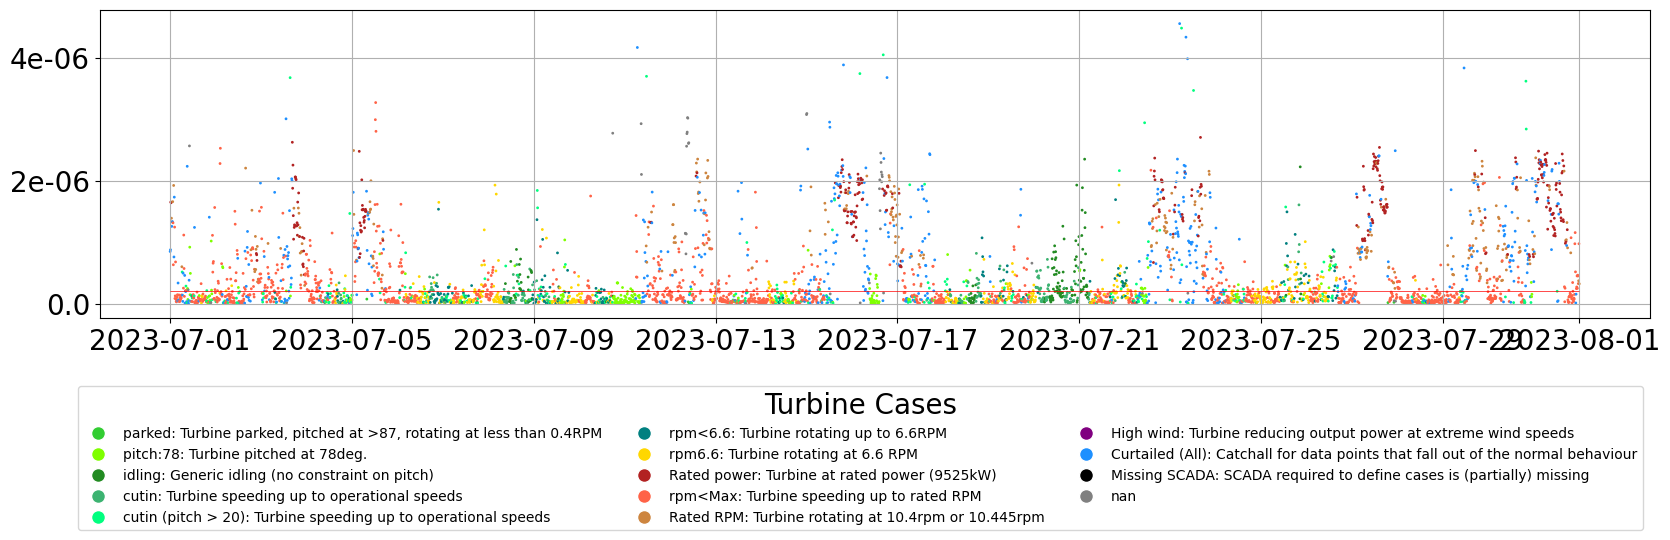

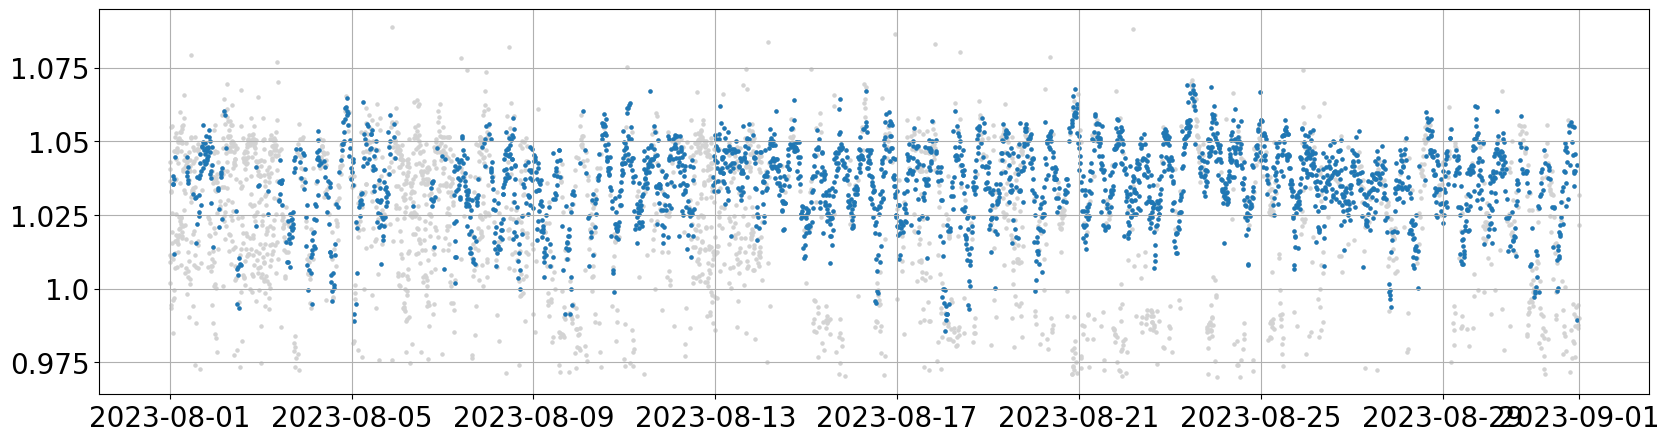

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)


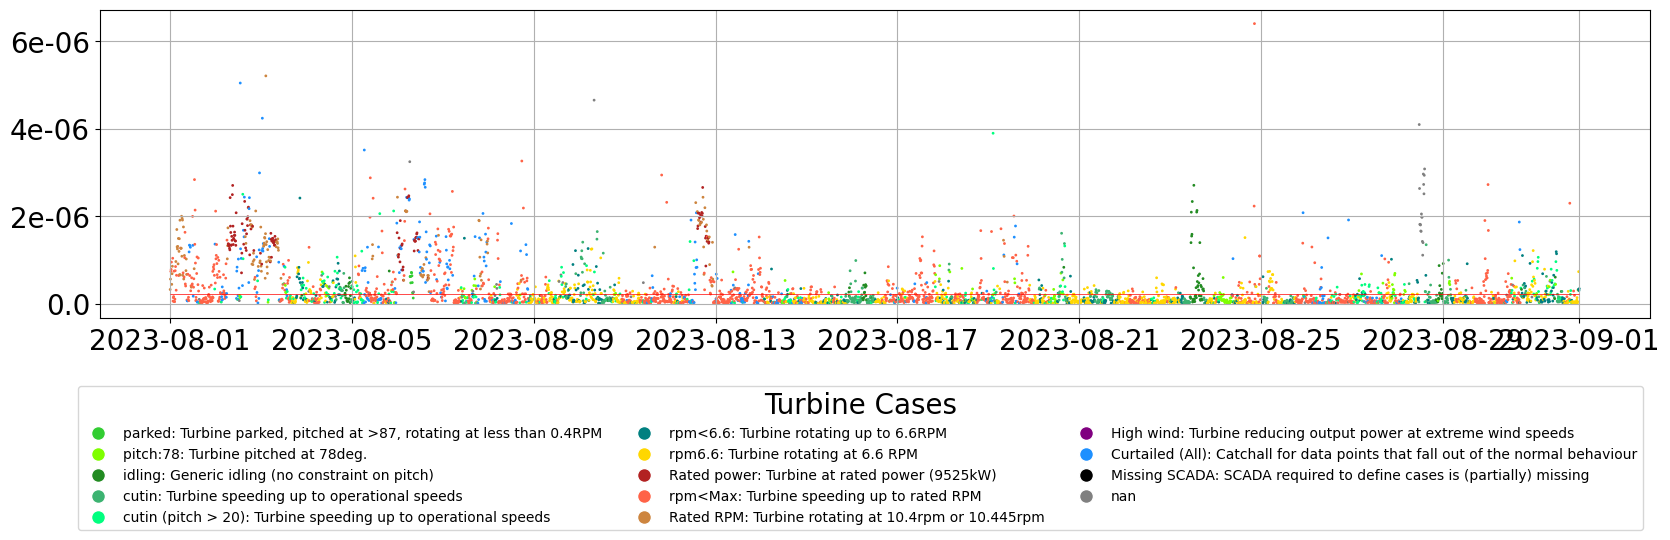

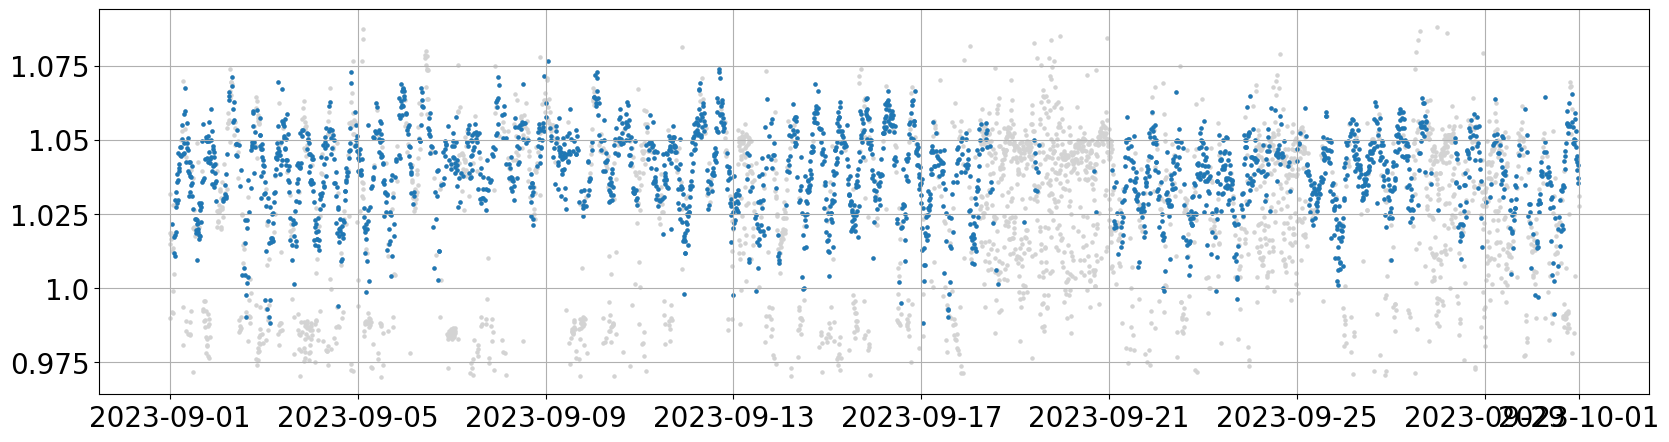

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)


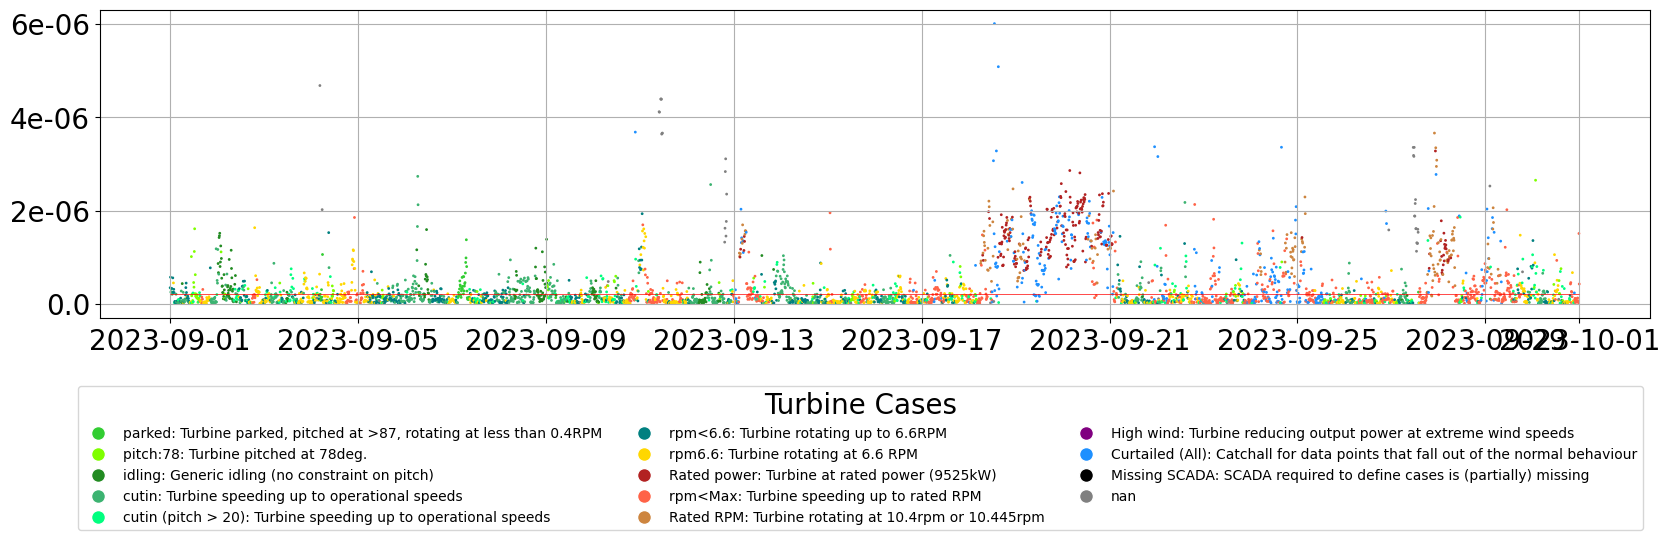

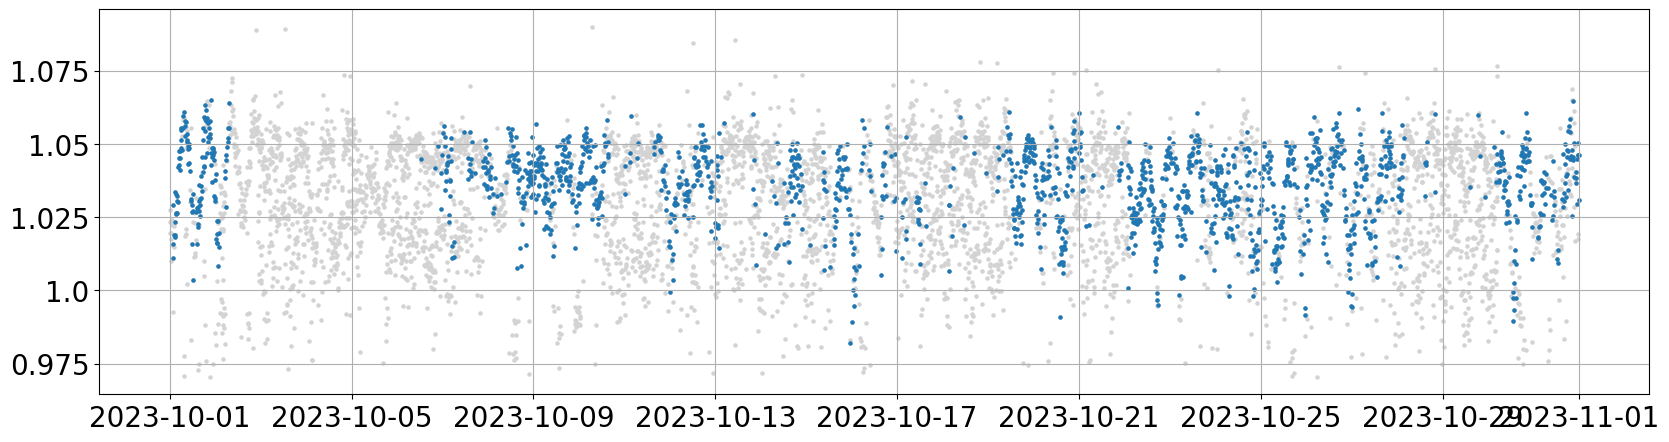

C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)
C:\Users\Max\AppData\Local\Temp\ipykernel_7324\3276135344.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(rounded_yticks)


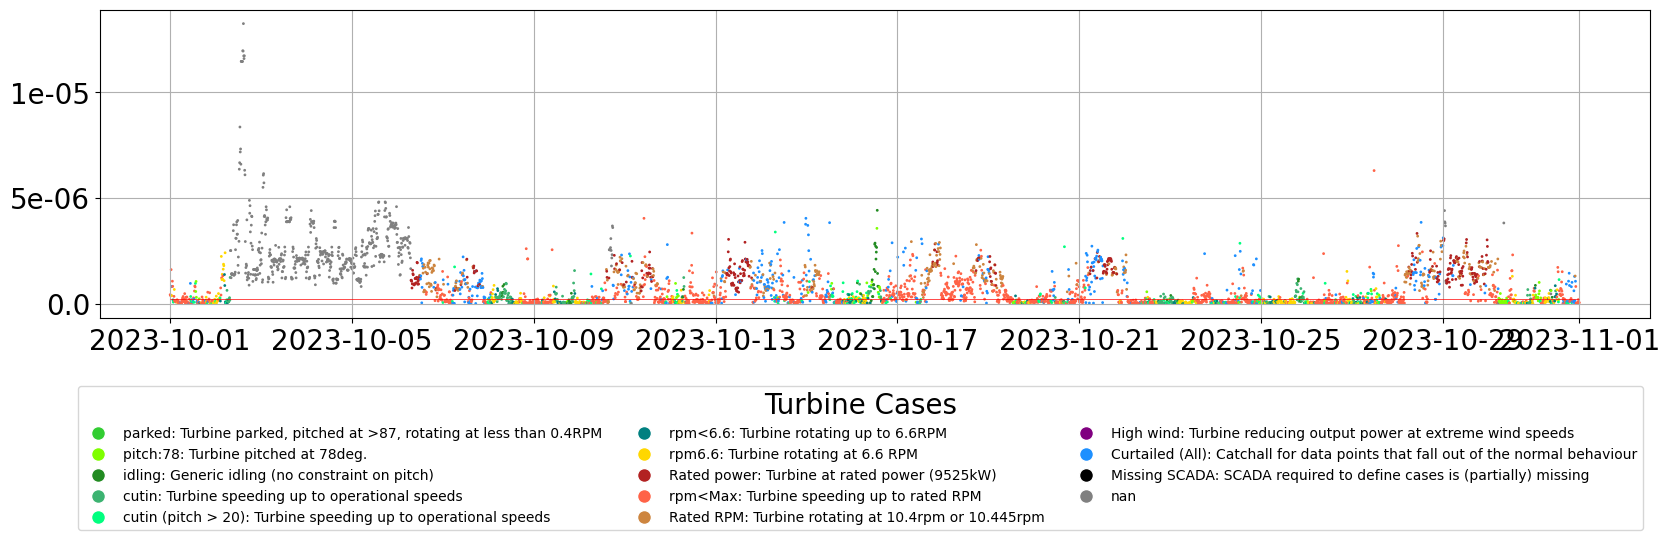

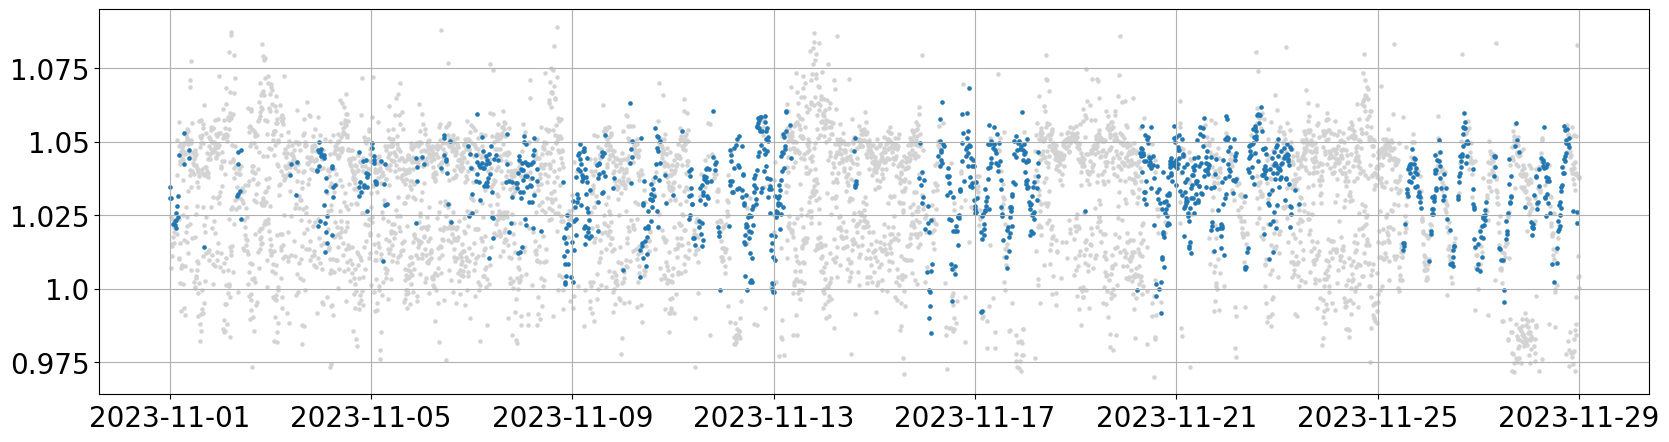

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 2023-11-01 00:00:00+00:00        tomato
2023-11-01 00:10:00+00:00        tomato
2023-11-01 00:20:00+00:00        tomato
2023-11-01 00:30:00+00:00        tomato
2023-11-01 00:40:00+00:00        tomato
                                ...    
2023-11-28 23:20:00+00:00    dodgerblue
2023-11-28 23:30:00+00:00    dodgerblue
2023-11-28 23:40:00+00:00    dodgerblue
2023-11-28 23:50:00+00:00    dodgerblue
2023-11-29 00:00:00+00:00    dodgerblue
Freq: 10T, Name: case_color, Length: 4033, dtype: object

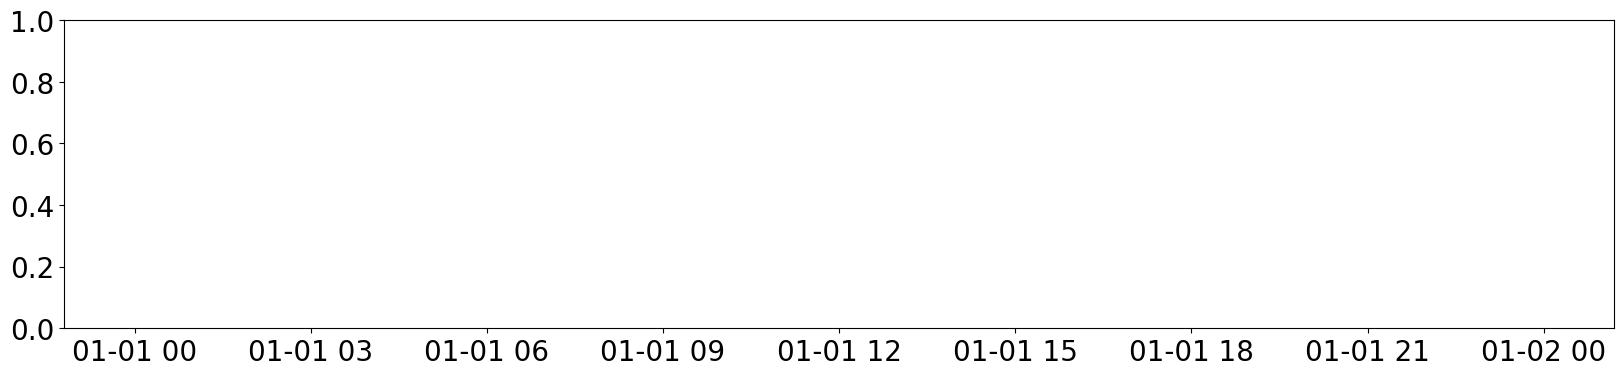

In [424]:
predictions_virutal_ensemble_plot = predictions_virutal_ensemble.copy()
predictions_virutal_ensemble_plot['case_color'] = case_IDs['case_color']

from dateutil.relativedelta import relativedelta
start = mpe_ss_data.index[0]
end  = mpe_ss_data.index[-1]
color_map = {category: palette[i % len(palette)] for i, category in enumerate(categories)}

while start < end:
    intermediate = start + relativedelta(months=1)
    plt.figure(figsize=(20,5))
    plt.scatter(ss2_reference_based[start:intermediate].index, ss2_reference_based[start:intermediate]['mean_frequency'], label='SS2 reference-based', s=5, color='lightgrey')
    plt.scatter(ss2_smart_tracking[start:intermediate].index, ss2_smart_tracking[start:intermediate]['frequency'], label='SS2 smart tracking', s=5)
    # Get current y-ticks
    current_yticks = plt.gca().get_yticks()

    # Round y-ticks to 2 decimal places
    rounded_yticks = np.round(current_yticks, 6)

    # Set new y-tick labels
    plt.gca().set_yticklabels(rounded_yticks)
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(20,4))
    plt.scatter(
        predictions_virutal_ensemble[start:intermediate].index,
        predictions_virutal_ensemble[start:intermediate]['knowledge_uncertainty'],
        label='SS2 model predictions',
        c=predictions_virutal_ensemble_plot[start:intermediate]['case_color'],
        cmap = color_map,
        s=1)
    plt.hlines(uncertainty_lim, start, intermediate, color='red', linewidth=0.5)
        # Create custom handles for the legend
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=case,
                                markerfacecolor=color, markersize=10) for case, color in zip(cases, palette)]
    # Create custom legend
    plt.legend(handles=legend_handles, title="Turbine Cases", fontsize=10, loc='upper right', bbox_to_anchor=(1, -0.2), ncol=3)
    plt.grid(True)
    # Get current y-ticks
    current_yticks = plt.gca().get_yticks()

    # Round y-ticks to 2 decimal places
    rounded_yticks = np.round(current_yticks, 6)

    # Set new y-tick labels
    plt.gca().set_yticklabels(rounded_yticks)
    start = intermediate


In [456]:
palette = [
    'limegreen',
    'chartreuse',
    'forestgreen',
    'mediumseagreen',
    'springgreen',
    'teal',
    'gold',
    'firebrick',
    'tomato',
    'peru',
    'purple',
    'dodgerblue',
    'black',
    'grey'
    ]

In [ ]:
predictions_virutal_ensemble_plot.to_parquet(os.path.join(data_folder, 'paper','3', '3.3', 'prediction_virtual_ensemble.parquet'))

nan


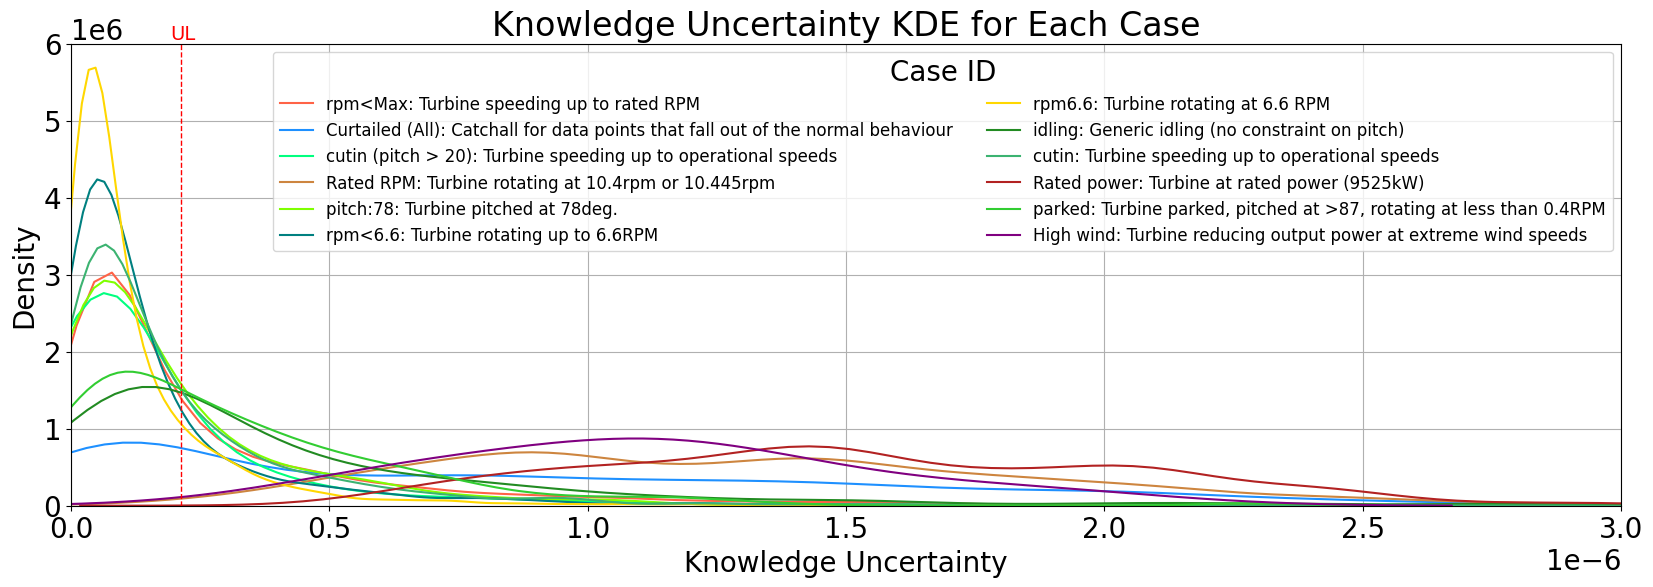

In [494]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df

# Create a figure
plt.figure(figsize=(20, 6))

# Loop through each unique case
unique_cases = predictions_virutal_ensemble_plot['case_ID'].unique()
for case_ in unique_cases:
    try:
        # Filter the DataFrame for the current case
        case_data = predictions_virutal_ensemble_plot[predictions_virutal_ensemble_plot['case_ID'] == case_]

        # Get the color for this case
        case_color = case_data['case_color'].iloc[0]
        case_data.rename(columns={'knowledge_uncertainty': 'Knowledge Uncertainty'}, inplace=True)

        # Plot the KDE for this case
        sns.kdeplot(case_data['Knowledge Uncertainty'], label=case_, color=case_color)
    except:
        print(case_)


# Add title and legend
plt.title('Knowledge Uncertainty KDE for Each Case')
plt.legend(title='Case ID', ncol=2, fontsize=12, loc='upper right', bbox_to_anchor=(1, 1))
plt.xlim(0, 3e-6)
plt.vlines(uncertainty_lim, 0, 6e6, color='red', linewidth=1, linestyle='dashed')
plt.ylim(0, 6e6)
plt.text(uncertainty_lim*0.9, 6e6*1.01, 'UL', color='red', fontsize=14, rotation=0)
# Show the plot
plt.grid(True)
plt.show()